# ESR - Electrical Symbol Recognition [(github)](https://github.com/rdstern90/DSBA-6165-Project)
## Object detection using yolov7
Rich Stern & Emil Svensson

In [1]:
import os
import random
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from google.colab import files

# get utility functions from github-repo
!wget -qq https://raw.githubusercontent.com/rdstern90/DSBA-6165-Project/main/YOLOv7_training/utility_funcs.py
import utility_funcs
# from utility_funcs import show_img, plot_results_simple


random_state = 42

# Introduction 
On building plans, a potentially large number of electrical symbols can be present to illustrate the location where i.e. outlets and light switches should be installed. Identifying and counting these symbols from image data is potentially useful for a contractor bidding on a project, based on the drawings supplied by the customer.

The symbols 
In this notebook different custom datasets containig crops of electrical building plans    and the impact on accuracy and training speed/performance for few different model settings will be explored. The pytorch-based implementation provided by the authors of the original yolov7 paper will be used: https://github.com/WongKinYiu/yolov7

##Two types of data
### Manually labeled
The image data was sourced from [ftp.txdot.gov/plans](https://ftp.txdot.gov/plans) and labels were manually created using a tool called [label-studio](https://labelstud.io/). This data is essential for testing but has also been used for model training.

### Generated
Plan images without any symbols of interest are used as a background, on which generated symbols are overlayed to create sample images. The idea is to investigate how good results can be accomplished using this "code-based" approach instead of just relying on data tediously labeled by humans.

# References
#### Simple guide to get started
*   https://medium.com/mlearning-ai/object-detection-with-yolov7-a74fa1f03c7e


#### Additional command line examples for inference/testing
*   https://blog.paperspace.com/train-yolov7-custom-data/

#### Changing anchor boxes
*   https://towardsdatascience.com/yolov7-a-deep-dive-into-the-current-state-of-the-art-for-object-detection-ce3ffedeeaeb
*   https://github.com/Chris-hughes10/Yolov7-training/

## Full size plans - Manually labeled

In [2]:
!gdown -qq 1uLE4MTxxoYkrX0V3GD3ycrAbRqMPaA3C
!unzip -qq input_data.zip

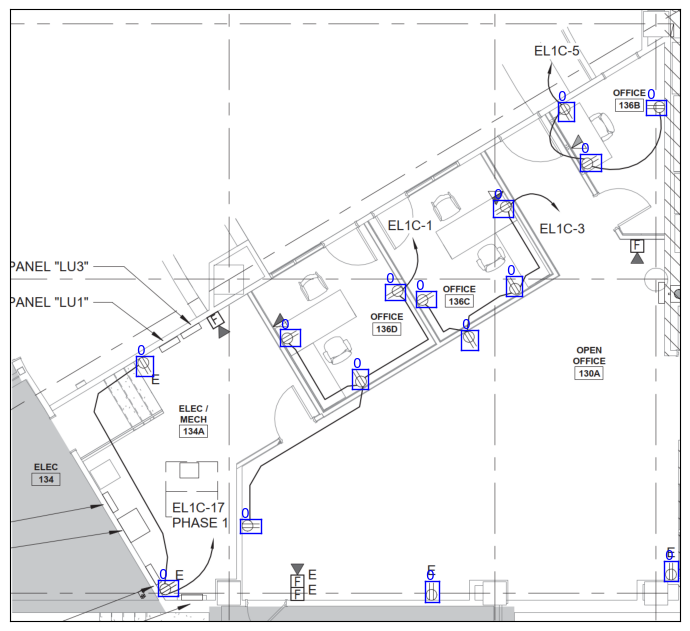

In [7]:
utility_funcs.show_img2("./input_data/with_symbols/images/", num_imgs=1, labels=True)

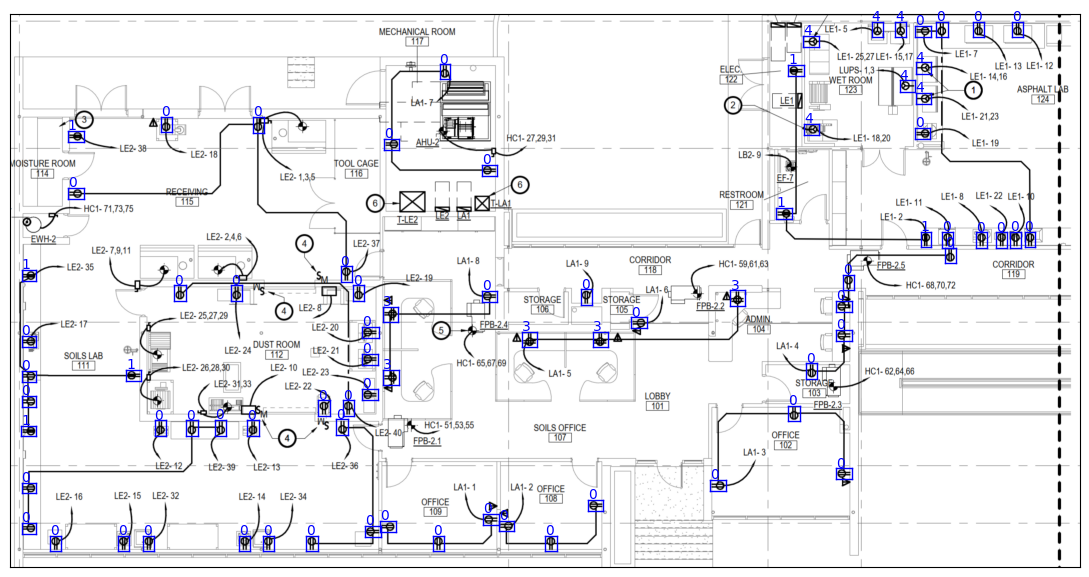

In [3]:
utility_funcs.show_img2("./input_data/with_symbols/images/", num_imgs=1, labels=True)

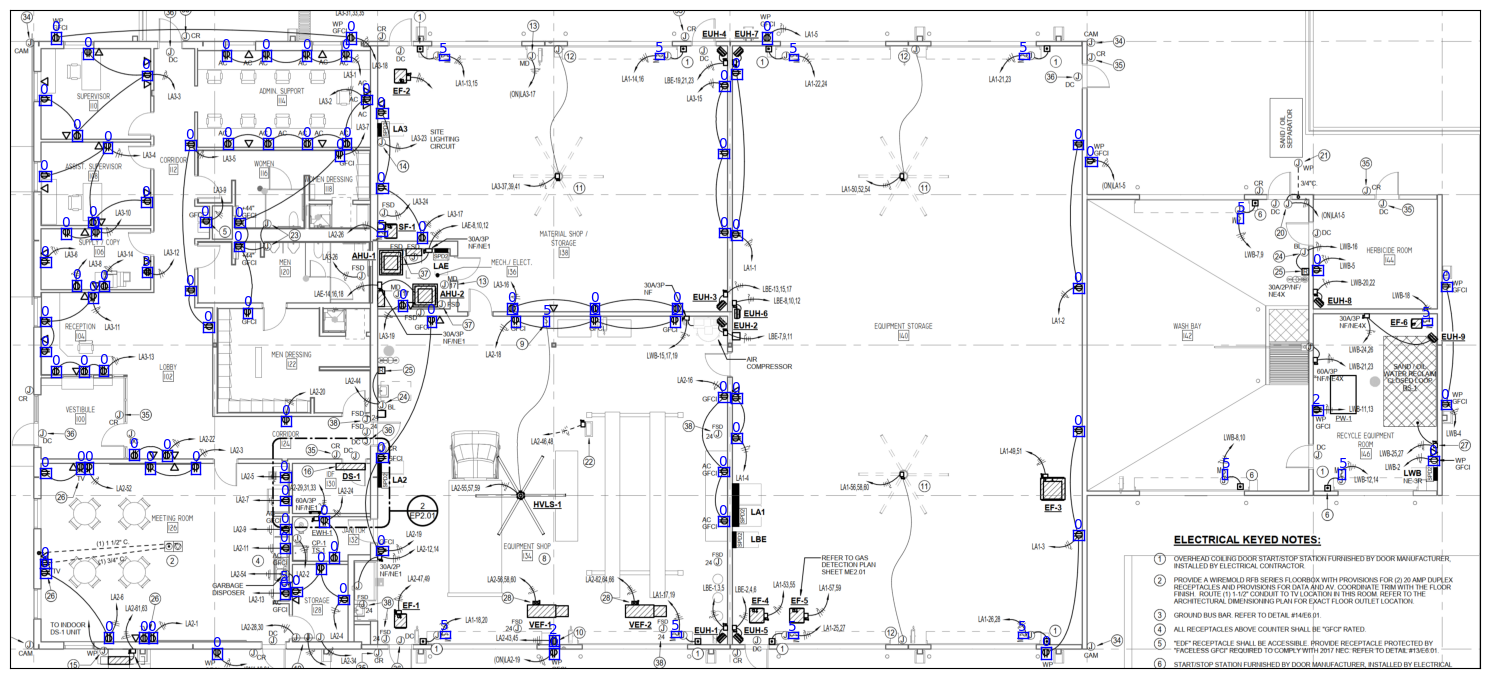

In [5]:
utility_funcs.show_img2("./input_data/with_symbols/images/", num_imgs=1, labels=True)

Note that the symbols that will actually be used have label class id = 0 or 3. In the plans above, 0 correspond to 'duplex' and 3 to 'quad' (quadplex).

## Clone original yolov7 implementation
Pytorch is used for the backend and the repo builds on previous models in the YOLO family, such as YOLOR (You Only Learn One Representation)

In [2]:
!git clone https://github.com/WongKinYiu/yolov7.git

# download training weights
!wget -qq https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

Cloning into 'yolov7'...
remote: Enumerating objects: 1139, done.
remote: Total 1139 (delta 0), reused 0 (delta 0), pack-reused 1139
Receiving objects: 100% (1139/1139), 70.41 MiB | 28.04 MiB/s, done.
Resolving deltas: 100% (488/488), done.


## Generating training data

Due to the relative simple nature of these symbols and the lack of pre-existing labeled data, an attempt has been done to generate training data from scratch. This process is not covered in this notebook which focuses on model training and evaluation

## Creating training and test samples from full size images (manually labeled)
With imagefiles up to 5429x2573 px in size, some sort of sampling/splitting is necessary. The sampling strategy employed starts from the generation of a rectangular grid of points (spaced according to a target overlap variable. Each grid point functions as a seed which is used as the top left corner for a potential image sample. That seed may or may not be used directly, depending on if the sample image border intersects a labeled symbol or not. If the sample edge intersects a symbol, random small translations are tested until a sample can succesfully be saved. The process/algorithm that does this can be found in this notebook (available in the github repository):
```
extract_symbols_generate_yolo_data.ipynb
```
Since the yolov7 model has built in image-augmenation for translation and mosaic (i.e. combining multiple images) it was determined that the value of setting a high overlap parameter and generating more sample images (different images but containing the same bounding boxes) is limited. The target overlap variable used in the end was 0.2 and this rendered 270 sample images (size 512x512 px)

All input files:
```
['plan01_2019-02_RFC_38-18197-Rebid-Plans_24.png',
 'plan02_2019-06_05-18241-plans_28.png',
 'plan03_2019-06_15-18158-plans_76.png',
 'plan04_2019-06_RFC_15-18248-plans_14.png',
 'plan05_2019-07_VCSLC_16-18700-plans_96.png',
 'plan06_2019-08_13-18177-plans_70.png',
 'plan07_2019-08_Bexar_0915-12-602_62.png',
 'plan07_2019-08_Bexar_0915-12-602_64.png',
 'plan06_2019-08_13-18177-plans_69b.png']
```

## Test data (manually labeled)
Two test datasets are used for evaluation.
*   set1 will be generated initially just by doing a train, valid, test split on the 270 images derived from the manually labeled full size plans
*   set2 consists of samples derived from different plans, some not sourced from [ftp.txdot.gov/plans](https://ftp.txdot.gov/plans)

```
['plan20_not_txdot_bp_res-plans_8.png',
 'plan21_not_txdot_bp_res-plans_9.png',
 'plan22_not_txdot_Electrical-layout-plan-house-Sat-Apr-2017-05-48-30.jpg',
 'plan23_not_txdot_House_Floor_Plans_23.png',
 'plan24_not_txdot_House_Floor_Plans_24.png',
 'plan25_not_txdot_how_to_read_electrical_plans_all_outlets.jpg',
 'plan08_2019-08_Culberson_0003-01-055_Vol_2_181.png',
 'plan09_2019-11_201859-20-01-Plans_13.png',
 'plan17_2020-12_20-20042-plans_16.png',
 'plan03_2019-06_15-18158-plans_77crop.png']
```

# Training with manually labeled images

In [7]:
if "manual_training_data_020.zip" not in os.listdir():
    !gdown -qq 1UrMlK170RUJ93a7tMMmnkDRDCjoB3WqX
!unzip -qq manual_training_data_020.zip
!rm manual_training_data_020_info.txt
!rm manual_training_data_020.zip

Each line in the .csv file "manually_labeled_images" represents a bounding box present in an image in the dataset.

In [8]:
df = pd.read_csv("manually_labeled_images.csv")
!rm manually_labeled_images.csv
print(f"Number of images in dataset: {len(df['image'].unique())}")

Number of images in dataset: 270


In [9]:
df.rename(columns={'type':'object_label'}, inplace=True)
df.head(20)

bbx_id object_label   xmin   xmax   ymin   ymax  crop_size  \
0      0.0       duplex  171.0  203.0  115.0  138.0        512   
1      1.0       duplex  249.0  272.0  106.0  138.0        512   
2      2.0       duplex  203.0  236.0  134.0  156.0        512   
3      3.0       duplex  171.0  203.0  231.0  254.0        512   
4      4.0       duplex  204.0  235.0  264.0  286.0        512   
5      5.0       duplex  261.0  283.0  352.0  382.0        512   
6      6.0       duplex  365.0  388.0  352.0  383.0        512   
7      7.0       duplex  281.0  304.0  250.0  277.0        512   
8      8.0       duplex  365.0  387.0  250.0  277.0        512   
9      9.0       duplex  429.0  462.0  267.0  290.0        512   
10    10.0       duplex  432.0  464.0  153.0  176.0        512   
11    11.0       duplex  394.0  417.0  106.0  138.0        512   
12     6.0       duplex   18.0   41.0  329.0  360.0        512   
13     8.0       duplex   18.0   40.0  227.0  254.0        512   
14     9.0       duplex   82.0  115.0  244.0  267.0        512   
15    10.0       duplex   85.0  117.0  130.0  153.0        512   
16    11.0       duplex   47.0   70.0   83.0  115.0        512   
17     NaN          NaN    NaN    NaN    NaN    NaN        512   
18    12.0       duplex  459.0  481.0   95.0  125.0        512   
19    16.0       duplex  410.0  441.0  217.0  239.0        512   

               image  image_id  has_annotation  class_id  
0    0000_plan01.png       0.0            True       0.0  
1    0000_plan01.png       0.0            True       0.0  
2    0000_plan01.png       0.0            True       0.0  
3    0000_plan01.png       0.0            True       0.0  
4    0000_plan01.png       0.0            True       0.0  
5    0000_plan01.png       0.0            True       0.0  
6    0000_plan01.png       0.0            True       0.0  
7    0000_plan01.png       0.0            True       0.0  
8    0000_plan01.png       0.0            True       0.0  
9    0000_plan01.png       0.0            True       0.0  
10   0000_plan01.png       0.0            True       0.0  
11   0000_plan01.png       0.0            True       0.0  
12   0001_plan01.png       1.0            True       0.0  
13   0001_plan01.png       1.0            True       0.0  
14   0001_plan01.png       1.0            True       0.0  
15   0001_plan01.png       1.0            True       0.0  
16   0001_plan01.png       1.0            True       0.0  
17  0002e_plan01.png       2.0           False      -1.0  
18   0003_plan01.png       3.0            True       0.0  
19   0003_plan01.png       3.0            True       0.0

There are 2 classes in the dataset:

(-1 is used to denote a background image, the label text file for a background image that is empty, this is not considered a real class)

In [6]:
print(df["object_label"].unique())
print(df["class_id"].unique())

['duplex' nan 'quad']
[ 0. -1.  1.]


In [7]:
df.groupby(["object_label"])["bbx_id"].count()

object_label
duplex    631
quad      129
Name: bbx_id, dtype: int64

### Creating a concatenated string based on dummy variables
...to be used in the next step for stratified sampling

In [10]:
dfg = pd.concat([df["image"], pd.get_dummies(df["class_id"], "cid")], axis=1)
dfg = dfg.groupby(["image"]).max()
dfg.head()

cid_-1.0  cid_0.0  cid_1.0
image                                       
0000_plan01.png          0        1        0
0001_plan01.png          0        1        0
0002e_plan01.png         1        0        0
0003_plan01.png          0        1        0
0004_plan01.png          0        1        0

In [11]:
cid_combination = []
for _, row in dfg.iterrows():
    cid_combination.append(str(row["cid_-1.0"])+"-"+str(row["cid_0.0"])+"-" + str(row["cid_1.0"]))

dfg["cid_combination"] = cid_combination
print(dfg["cid_combination"].value_counts())

0-1-0    131
0-1-1     63
1-0-0     61
0-0-1     15
Name: cid_combination, dtype: int64


### Create trainining, validation and test sample
The remaining images can now be sampled in a stratifed fashion, making sure that especially the relatively fewer 'swich' labeles are represented in both the training and validation set

This can be done with the well known sklearn train_test_split function

In [12]:
train_frac = 0.6
valid_frac = 0.25
test_frac = 0.15

x = dfg.index.values
y = dfg["cid_combination"]
train_files, test_files, y_train, y_test = train_test_split(x, y, test_size=test_frac, stratify=y, random_state=42)
train_files, valid_files, y_train, y_valid = train_test_split(train_files, y_train, test_size=valid_frac/(1-test_frac), stratify=y_train, random_state=random_state)

print(f"n train: {len(train_files)}, n valid: {len(valid_files)}, n test: {len(test_files)} (ntot: {len(x)})")

n train: 161, n valid: 68, n test: 41 (ntot: 270)


#### Function *create_stratified_samples* in utility_funcs.py combines all steps in one function for re-use:
Running the cell below shows the function defintion

In [3]:
??utility_funcs.create_stratified_samples

#### Function move_images distributes the image and label data
A src_path=['imagespath', 'labelspath'] and sample lists of image filenames are passed as arguments to move images and labels into the yolov7 train, valid and test folders.

An empty list, i.e. train = [ ] can be specified to not move any files for that sample. Running the cell below shows the function defintion

In [6]:
??utility_funcs.move_images

In [13]:
src_paths = ["images_manual/", "labels_manual/"]
utility_funcs.move_images(src_paths, train_files, valid_files, test_files)

## Model b2
#### Making minimal modifications to the model configuration before starting training

In [3]:
# create a new custom config file by copying "yolov7.yaml...
# and changing line 2 where the number of classes is defined (originally 80 classes)

with open("/content/yolov7/cfg/training/yolov7.yaml", "r") as f:
    content = f.readlines()
    content[1] = "nc: 2  # number of classes\n"

with open("/content/yolov7/cfg/training/esr_v1.yaml", "w") as f:
    f.writelines(content)



# Create file that defines where..
# 1. the training, validation, test samples+labels are located
# 2. the number of classes
# 3. class names

with open("/content/yolov7/data/esr.yaml", "w") as f:
    f.write("train: ./yolov7/train\n")
    f.write("val: ./yolov7/valid\n")
    f.write("test: ./yolov7/test\n\n")
    f.write("# Classes\n")
    f.write("nc: 2  # number of classes\n")
    f.write("names: ['duplex', 'quad']")

In [ ]:
# create a new custom config file by copying "yolov7.yaml...
# and changing line 2 where the number of classes is defined (originally 80 classes)

with open("/content/yolov7/cfg/training/yolov7.yaml", "r") as f:
    content = f.readlines()
    content[1] = "nc: 2  # number of classes\n"

with open("/content/yolov7/cfg/training/esr_v1.yaml", "w") as f:
    f.writelines(content)


# Create file that defines where..
# 1. the training, validation, test samples+labels are located
# 2. the number of classes
# 3. class names

with open("/content/yolov7/data/esr.yaml", "w") as f:
    f.write("train: ./yolov7/train\n")
    f.write("val: ./yolov7/valid\n")
    f.write("test: ./yolov7/test\n\n")
    f.write("# Classes\n")
    f.write("nc: 2  # number of classes\n")
    f.write("names: ['duplex', 'quad']")

In [105]:
run_name = "run_b2"
epochs = 300

!python yolov7/train.py --workers 8 --device 0 --batch-size 32 --weights yolov7_training.pt --data yolov7/data/esr.yaml --img 512 --cfg yolov7/cfg/training/esr_v1.yaml --name $run_name --epochs $epochs

2023-04-23 01:07:03.850944: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 01:07:05.438096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Namespace(weights='yolov7_training.pt', cfg='yolov7/cfg/training/esr_v1.yaml', data='yolov7/data/esr.yaml', hyp='./yolov7/data/hyp.scratch.p5.yaml', epochs=300, batch_size=32, img_size=[512, 512], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=8, project='runs/train', entity=None, name='run_b2'

In [16]:
# save the best weights and other run outputs
run_zip = run_name+".zip"
basepath = "runs/train/"
wghts = "/weights"
best_wghts = "/best.pt"

!cp $basepath$run_name$wghts$best_wghts $basepath$run_name$best_wghts
!rm -rf $basepath$run_name$wghts
!cp -r $basepath$run_name $run_name
!rm -rf $basepath$run_name

!zip -qq -r $run_zip $run_name
files.download(run_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Note on "best" weights
The best weights are determined by a fitness score, which is a "weighted combination of [P, R, mAP@.5, mAP@.5-.95]" (from train.py).

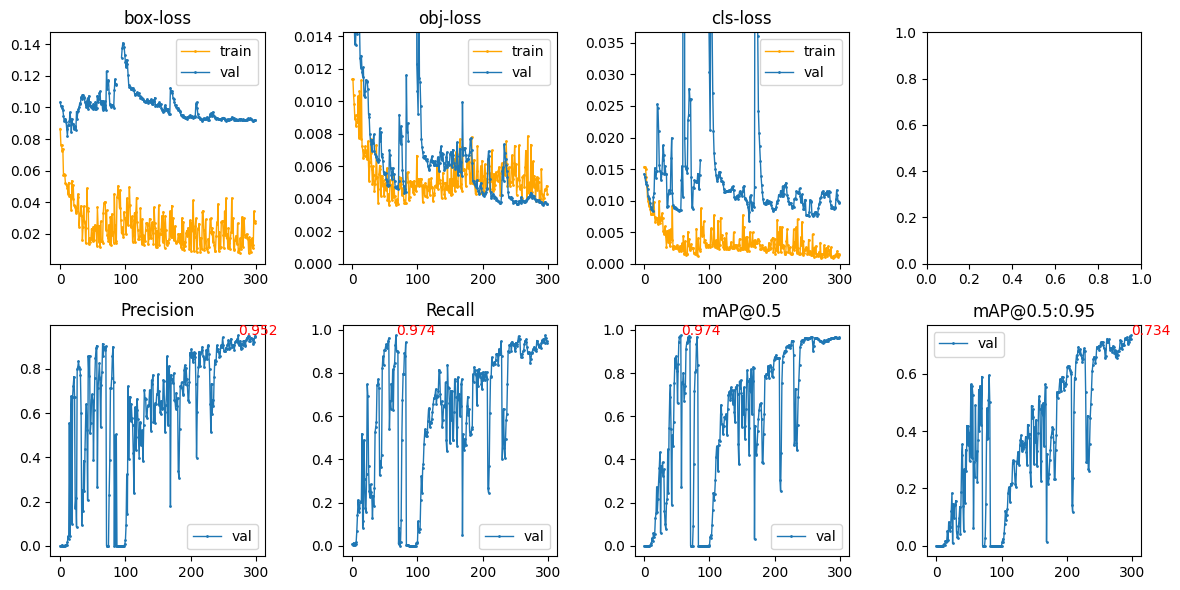

In [9]:
utility_funcs.plot_results_simple("run_b2/results.txt", annotate_best=True)

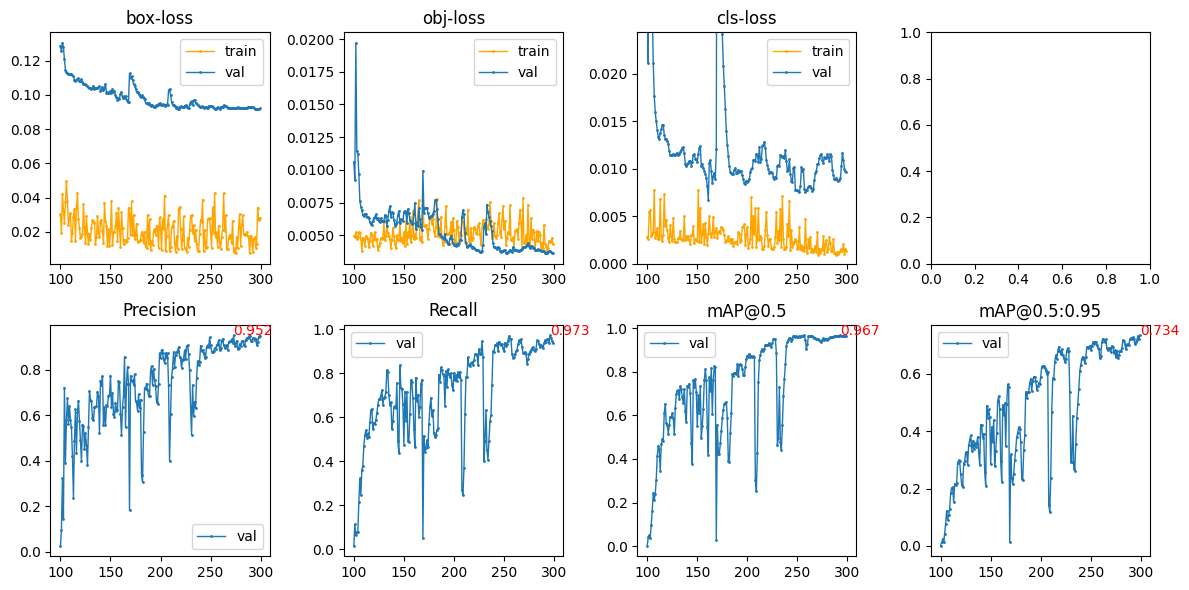

In [10]:
utility_funcs.plot_results_simple("run_b2/results.txt", start=100, annotate_best=True)

### Interpreting the output
The total loss consist of the box, objectness (obj) and classification (cls) loss. It is reported both for the training set and validation set. 

Precision and recall are composite scores for both classes (quad & duplex). These metrics will vary for different classes

mAP is an abbreviation for mean Average Precision. To calculate the mAP you need precision, recall and IoU (intersection over union, using the predicted and the ground truth bounding box). mAP is a type of AUC-score, using the precision and recall curve. The IoU value is used as a threshold to determine wether a predicted bounding box is considered "correct". Obviously, the higher that threshold is set, the higher the bar is for the model predictions to be deemed accurate. That's the basic explanation for why the best mAP\@0.5 is noticeably higher than mAP\@0.5:0.95   ([read more here)](https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173)

#### Run_b2 training results
From the plots we can see that the best recall and mAP@0.5 is achieved around epoch 70, while the precision and mAP@0.5:0.95 keeps increasing and reach their maximum values close to the maximum numer of epochs, 300.

Validation loss has not started to increase, so no obvious overfitting is occurring. The erratic behavior of all performance metrics suggests that maybe the learning rate is too high, or that something else is impeding the model's ability to learn efficiently.


In [5]:
# !rm -r $run_name
# !rm run_b2.zip

## Evaluate run_b2
#### run test.py on test image set1 with model b2 weights

In [4]:
if 'run_b2' not in os.listdir():
    if 'run_b2.zip' not in os.listdir():
        !gdown -qq 1FZ_yqbyvqwQt5xop2FvI5krZmmn1mawh
    !unzip -qq run_b2.zip

In [25]:
run_name_test = run_name+"_test"  # test run name
best_wght_path = run_name+"/best.pt"

!python yolov7/test.py --weights $best_wght_path --data yolov7/data/esr.yaml --img-size 512 --save-txt --task test --name $run_name_test --no-trace

Namespace(weights=['run_b2/best.pt'], data='yolov7/data/esr.yaml', batch_size=32, img_size=512, conf_thres=0.001, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='run_b2_test', exist_ok=False, no_trace=True, v5_metric=False)
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
test: Scanning 'yolov7/test/labels.cache' images and labels... 41 found, 0 mis

Use v5_metric - best possible recall = 1

In [14]:
run_name = "run_b2"
run_name_test = run_name+"_test02conf_v5metric"  # test run name
best_wght_path = run_name+"/best.pt"

!python yolov7/test.py --weights $best_wght_path --data yolov7/data/esr.yaml --img-size 512 --save-txt --task test --name $run_name_test --no-trace --v5-metric

Namespace(weights=['run_b2/best.pt'], data='yolov7/data/esr.yaml', batch_size=32, img_size=512, conf_thres=0.001, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='run_b2_test02conf_v5metric', exist_ok=False, no_trace=True, v5_metric=True)
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
test: Scanning 'yolov7/test/labels' images and labels... 41 fou

In [27]:
# save test results
test_zip = run_name_test+".zip"
basepath = "runs/test/"

!cp -r $basepath$run_name_test $run_name_test
!rm -rf $basepath$run_name_test

!zip -qq -r $test_zip $run_name_test
files.download(test_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inspecting the predictions
..and comparing them to the ground-truth labels. **Note that that the confidence threshold is left at its default-value of 0.001!**

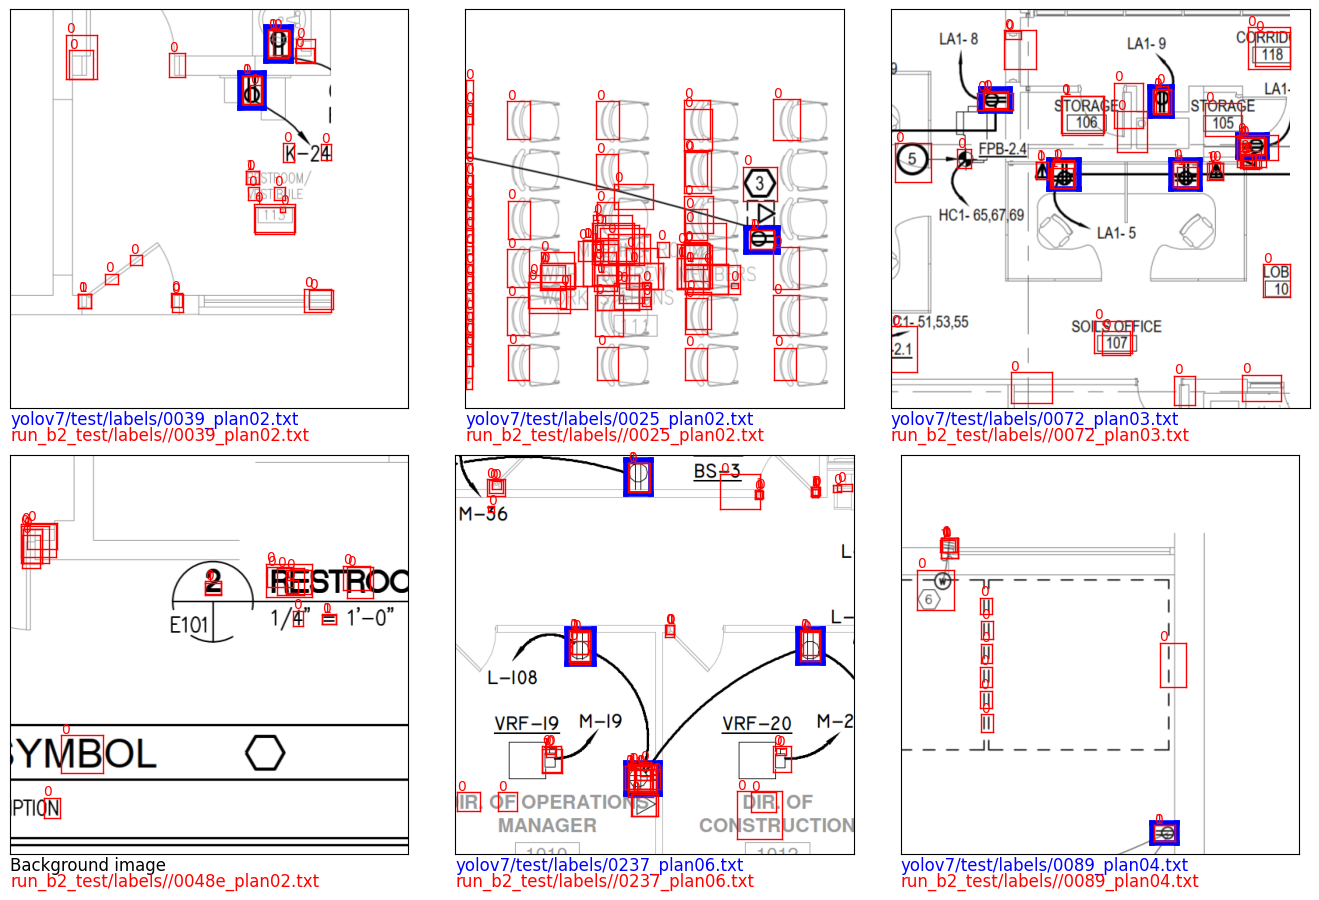

In [3]:
testimgpaths = ['yolov7/test/images/0039_plan02.png', 'yolov7/test/images/0025_plan02.png', 'yolov7/test/images/0072_plan03.png', 
                'yolov7/test/images/0048e_plan02.png', 'yolov7/test/images/0237_plan06.png', 'yolov7/test/images/0089_plan04.png']

utility_funcs.show_img2(testimgpaths, "run_b2_test/labels/", clr1="blue", clr2="red")

#### Re-run test with increased confidence threshold (0.2)

In [14]:
run_name_test = "run_b2_test_02conf"  # test run name
best_wght_path = "run_b2/best.pt"

!python yolov7/test.py --weights $best_wght_path --data yolov7/data/esr.yaml --img-size 512 --save-txt --task test --name $run_name_test --no-trace --conf-thres 0.2

Namespace(weights=['run_b2/best.pt'], data='yolov7/data/esr.yaml', batch_size=32, img_size=512, conf_thres=0.2, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='run_b2_test_0.2conf', exist_ok=False, no_trace=True, v5_metric=False)
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
test: Scanning 'yolov7/test/labels' images and labels... 41 found, 0 mis

Interesting to note is that precision and recall values output from the test.py script are unaffected while mAP values are decreased slighlty.

In [22]:
## save test results
test_zip = run_name_test+".zip"
basepath = "runs/test/"

!cp -r $basepath$run_name_test $run_name_test
!rm -rf $basepath$run_name_test

!zip -qq -r $test_zip $run_name_test
files.download(test_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# base_dir = "./yolov7/test/images/"
# files = os.listdir(base_dir)
# testimgpaths = random.sample([base_dir+file for file in files],6)
# print(testimgpaths)

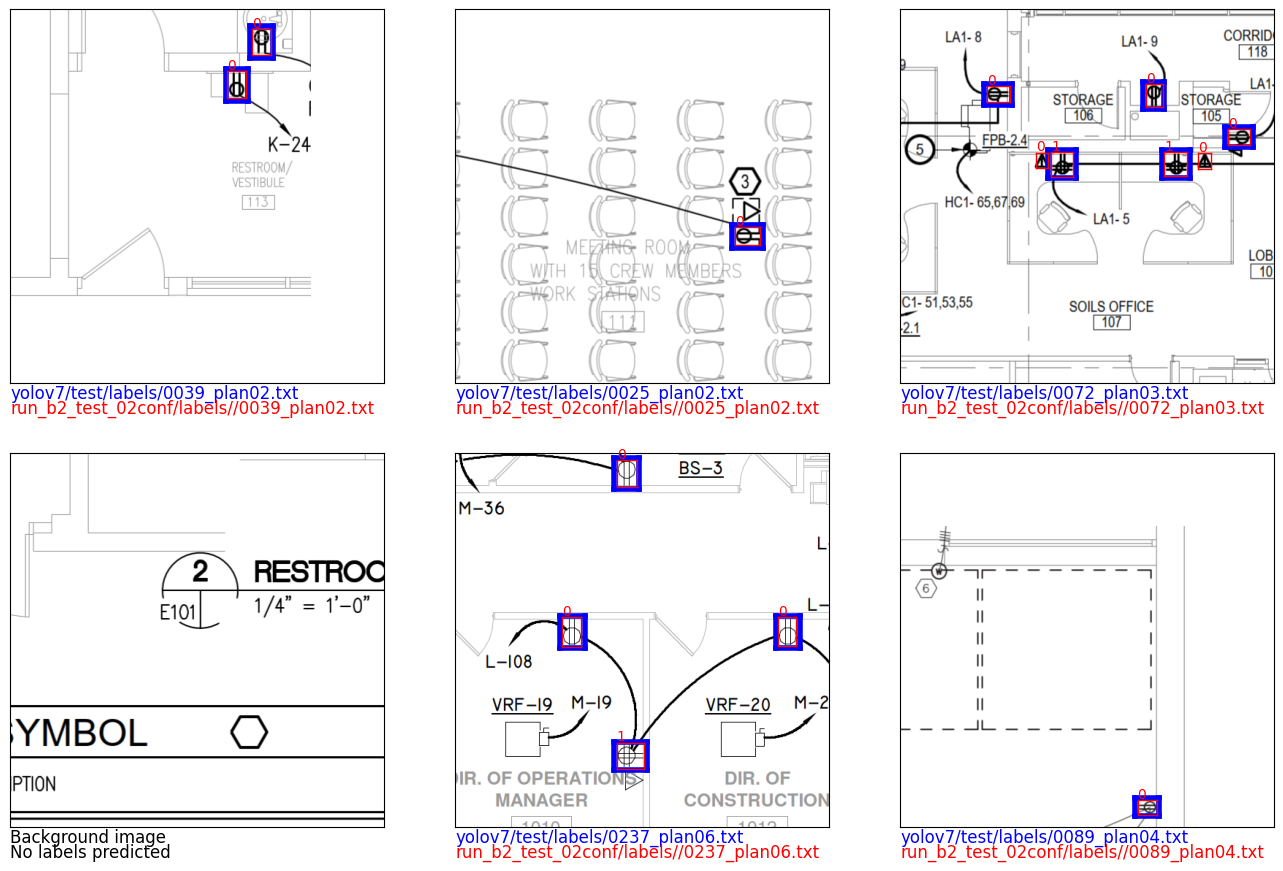

In [4]:
testimgpaths = ['yolov7/test/images/0039_plan02.png', 'yolov7/test/images/0025_plan02.png', 'yolov7/test/images/0072_plan03.png', 
                'yolov7/test/images/0048e_plan02.png', 'yolov7/test/images/0237_plan06.png', 'yolov7/test/images/0089_plan04.png']

utility_funcs.show_img2(testimgpaths, "run_b2_test_02conf/labels/", clr1="blue", clr2="red")

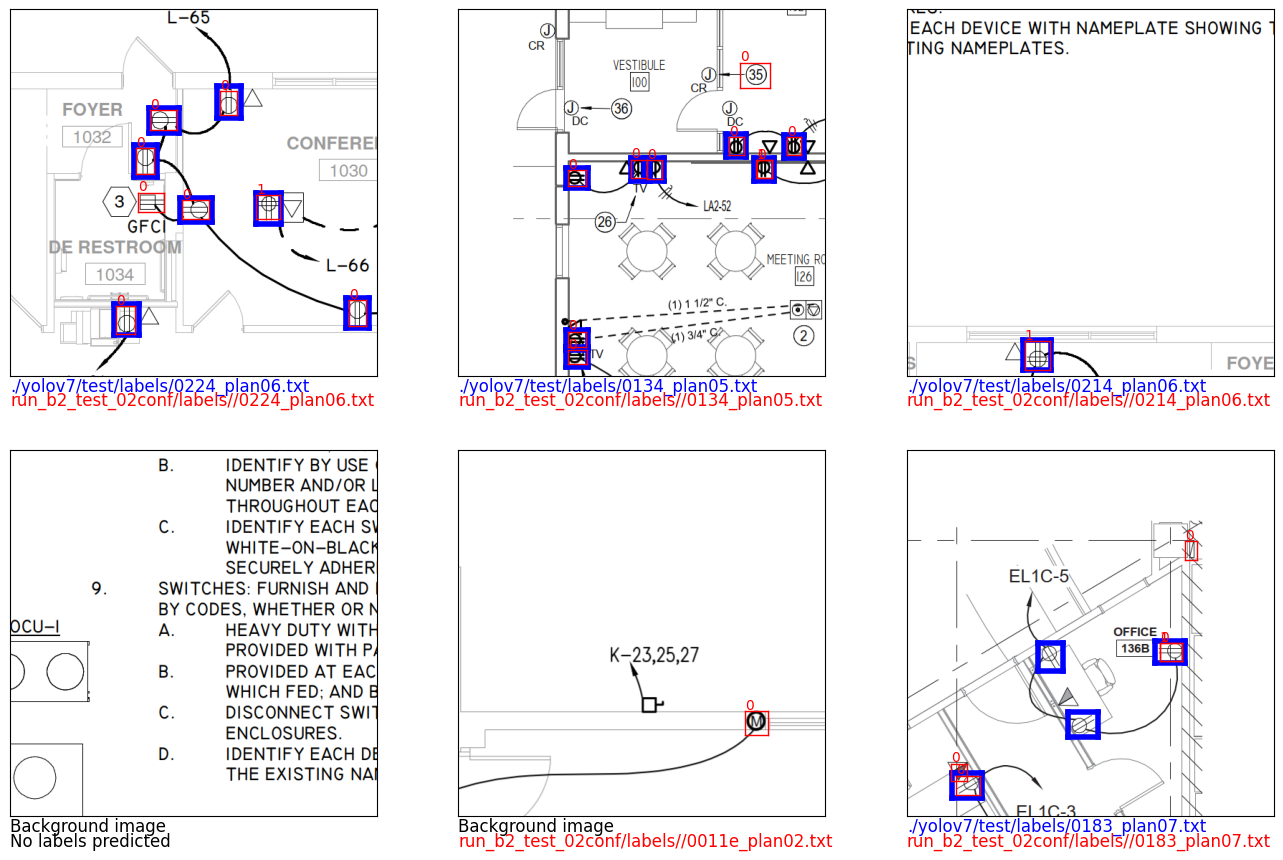

In [5]:
testimgpaths = ['./yolov7/test/images/0224_plan06.png', './yolov7/test/images/0134_plan05.png', './yolov7/test/images/0214_plan06.png',
                './yolov7/test/images/0210e_plan06.png', './yolov7/test/images/0011e_plan02.png', './yolov7/test/images/0183_plan07.png']

utility_funcs.show_img2(testimgpaths, "run_b2_test_02conf/labels/", clr1="blue", clr2="red")

With the confidence value increased, as expected, significantly fewer bounding box predictions are saved to the prediction label files. In the cell just above, two duplex symbols are not predicted accurately (bottom right). At this confidence level there are still a number of false positives, but not nearly as many as with the confidence threshold set to 0.001

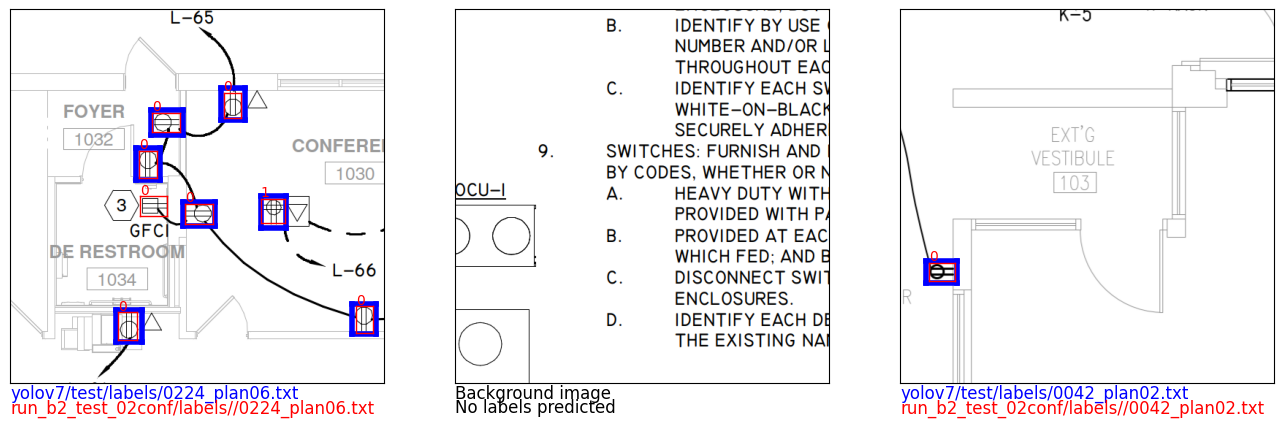

In [6]:
# by inputting the path to the test images, randomized sample images with  ground truth and predicted bounding boxes are shown
utility_funcs.show_img2("yolov7/test/images/", "run_b2_test_02conf/labels/", num_imgs=3, clr1="blue", clr2="red")

### b2 weights: Evaluate on test set2 (unseen plans, some not from txdot)

In [4]:
if "run_b2" not in os.listdir():
    if "run_b2.zip" not in os.listdir():
        !gdown -qq 1FZ_yqbyvqwQt5xop2FvI5krZmmn1mawh
    !unzip -qq run_b2.zip

In [5]:
!gdown -qq 1qtvl1TPhhH9zqFJUeS9q8t6ZUmLVx-3l
!unzip -qq test_manual_labels_unseen_plans.zip
!rm manually_labeled_images.csv

In [ ]:
!rm -r yolov7/test/
test_files = os.listdir("images_manual")
src_paths = ["images_manual/", "labels_manual/"]
utility_funcs.move_images(src_paths, [], [], test_files)

Using confidence threshold = 0.2

In [8]:
run_name_test = "run_b2_test_set2"  # test run name
best_wght_path = "run_b2/best.pt"

!python yolov7/test.py --weights $best_wght_path --data yolov7/data/esr.yaml --img-size 512 --save-txt --task test --name $run_name_test --no-trace --conf-thres 0.2 

Namespace(weights=['run_b2/best.pt'], data='yolov7/data/esr.yaml', batch_size=32, img_size=512, conf_thres=0.2, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='run_b2_test_set2', exist_ok=False, no_trace=True, v5_metric=False)
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
test: Scanning 'yolov7/test/labels' images and labels... 108 found, 0 missi

On the unseen data the performance is less stellar with an overall precision of 0.37 and recall of 0.55. The model is doing better with iedntidying duplex compared to quad symbols.

In [9]:
# save test results
test_zip = run_name_test+".zip"
basepath = "runs/test/"

!cp -r $basepath$run_name_test $run_name_test
!rm -rf $basepath$run_name_test

!zip -qq -r $test_zip $run_name_test
files.download(test_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
base_dir = "./yolov7/test/images/"
files = os.listdir(base_dir)
testimgpaths = random.sample([base_dir+file for file in files],6)
print(testimgpaths)

['./yolov7/test/images/0012e_plan22.png', './yolov7/test/images/0048_plan24.png', './yolov7/test/images/0037_plan24.png', './yolov7/test/images/0016_plan23.png', './yolov7/test/images/0006_plan21.png', './yolov7/test/images/0093_plan17.png']


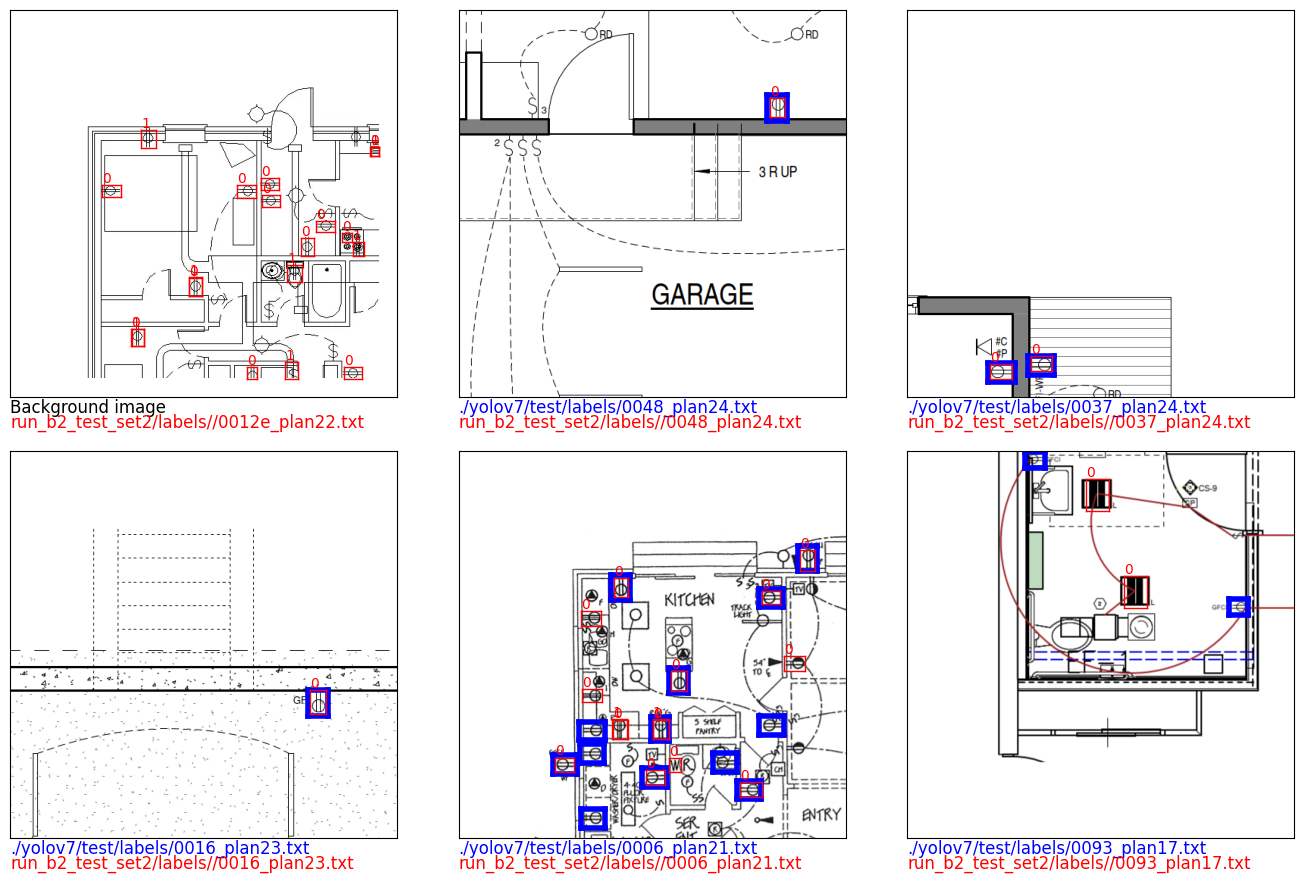

In [11]:
utility_funcs.show_img2(testimgpaths, "run_b2_test_set2/labels/", clr1="blue", clr2="red")

Comparing the ground truth bounding boxes to the predicted ones we can notice a lot of false positives (especially in top left). Missing red boxes is also consistent with the lower recall value.

# Explore model hyper-parameters
The hyper-parameters are specified in the file:
```
yolov7/data/hyp.scratch.p5.yaml
```

In [ ]:
with open("yolov7/data/hyp.scratch.p5.yaml", mode="r") as f:
  lines = f.readlines()

  for i, line in enumerate(lines):
    print(line[:-1])

lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.3  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 0.7  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.2  # image translation (+/- fraction)
s

#### For this object detection task it could be interesting to:
*   Try the adam optimizer
*   Try to change the loss function weights, e.g. increase **obj** and decrease **cls** to hopefully increase recall at the cost of precision, i.e. accurate classification of the label.


#### However...
first of all, it can be noted that some image augmentation parameters aren't ideal, most notably the scale parameter which now says that the image can be shrunk to 10%, or almost doubled to 190% of its actual size.

The mosaic probability of 1 will also be lowered
```
    scale: 0.9  # image scale (+/- gain)
    mosaic: 1.0  # image mosaic (probability) 
```

## Model b3
####  - Changing scale to 0.3 and mosaic to 0.5
The minimal changes made for model b2 are retained


In [ ]:
with open("yolov7/data/hyp.scratch.p5.yaml", mode="r") as f:
  lines = f.readlines()

with open("yolov7/data/hyp.esr.p5.yaml", mode="w") as f:
  for line in lines:
    if line.split(':')[0] == "scale":
      f.write("scale: 0.3  # image scale (+/- gain)\n")

    elif line.split(':')[0] == "mosaic":
      f.write("mosaic: 0.5  # image mosaic (probability)\n")

    else:
      f.write(line)

In [64]:
run_name = "run_b3"
epochs = 300

!python yolov7/train.py --workers 8 --device 0 --batch-size 32 --weights yolov7_training.pt --data yolov7/data/esr.yaml --img 512 --cfg yolov7/cfg/training/esr_v1.yaml --name $run_name --epochs $epochs --hyp yolov7/data/hyp.esr.p5.yaml

2023-04-23 20:13:27.919347: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 20:13:28.805813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Namespace(weights='yolov7_training.pt', cfg='yolov7/cfg/training/esr_v1.yaml', data='yolov7/data/esr.yaml', hyp='yolov7/data/hyp.esr.p5.yaml', epochs=300, batch_size=32, img_size=[512, 512], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=8, project='runs/train', entity=None, name='run_b3', exis

In [65]:
# save the best weights and other run outputs
run_zip = run_name+".zip"
basepath = "runs/train/"
wghts = "/weights"
best_wghts = "/best.pt"

!cp $basepath$run_name$wghts$best_wghts $basepath$run_name$best_wghts
!rm -rf $basepath$run_name$wghts
!cp -r $basepath$run_name $run_name
!rm -rf $basepath$run_name

!zip -qq -r $run_zip $run_name
files.download(run_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

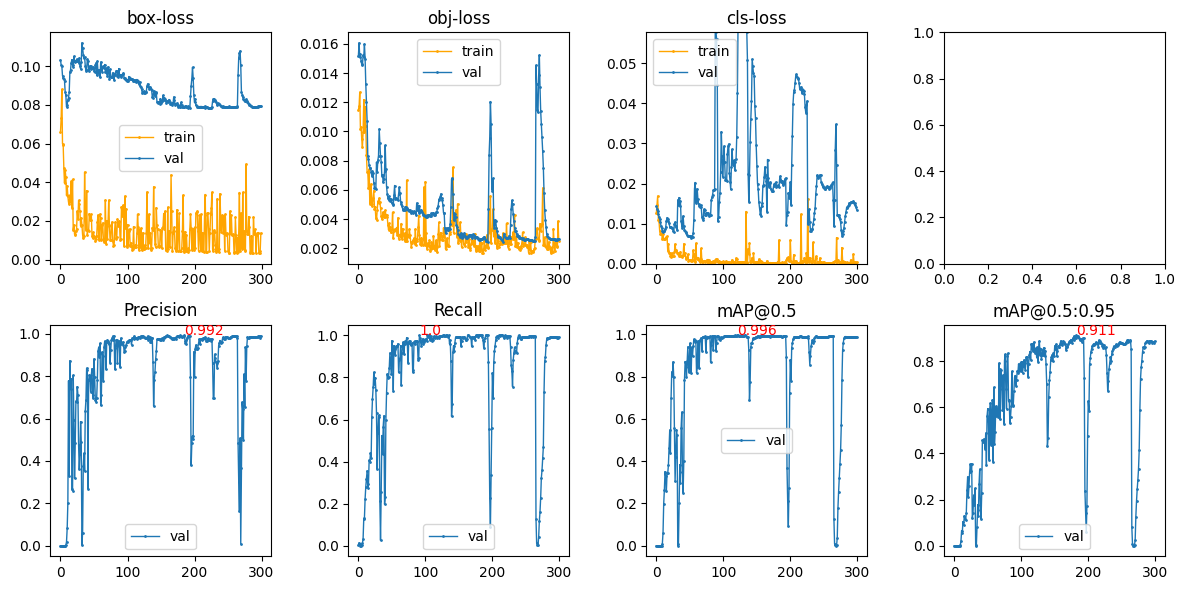

In [10]:
utility_funcs.plot_results_simple("run_b3/results.txt", annotate_best=True)

#### Run_b3 training results
Reducing the image augmentation clearly improved the training performance. Since the size of the symbols is similar in all images of interest, applying a very large scaling factor is counter-productive and adds no value.

Not only is performance better, it also appears that training is faster due to fewer "unhelpful" training samples.

In [ ]:
# !rm -r $run_name
# !rm run_b3.zip

## Evaluate run_b3
#### run test.py on test image set1 with model b3 weights

In [4]:
if "run_b3" not in os.listdir():
    if "run_b3.zip" not in os.listdir():
        !gdown -qq 191aXOwSO2hf6e4bRc4qhuf4zhdfoMGuG
    !unzip -qq run_b3.zip

In [5]:
if "test_manual_labels_020.zip" not in os.listdir():
    !gdown -qq 1ObgIwIKKa06vp4M2aq7SVz8Nh5tOLbq6
!unzip -qq test_manual_labels_020.zip


!rm -r yolov7/test  # remove existing test images and labels
test_files = os.listdir("test_manual_labels_020/images/")
src_paths = ["test_manual_labels_020/images/", "test_manual_labels_020/labels/"]
utility_funcs.move_images(src_paths, [], [], test_files)

!rm -r test_manual_labels_020

rm: cannot remove 'yolov7/test': No such file or directory


In [72]:
run_name_test = "run_b3_test"  # test run name
best_wght_path = "run_b3/best.pt"

!python yolov7/test.py --weights $best_wght_path --data yolov7/data/esr.yaml --img-size 512 --save-txt --task test --name $run_name_test --no-trace

Namespace(weights=['run_b3/best.pt'], data='yolov7/data/esr.yaml', batch_size=32, img_size=512, conf_thres=0.001, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='run_b3_test', exist_ok=False, no_trace=True, v5_metric=False)
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
test: Scanning 'yolov7/test/labels' images and labels... 41 found, 0 missing, 

In [73]:
# save test results
test_zip = run_name_test+".zip"
basepath = "runs/test/"

!cp -r $basepath$run_name_test $run_name_test
!rm -rf $basepath$run_name_test

!zip -qq -r $test_zip $run_name_test
files.download(test_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### run_b3: predcited labels on test set1 with 0.001 confidence threshold

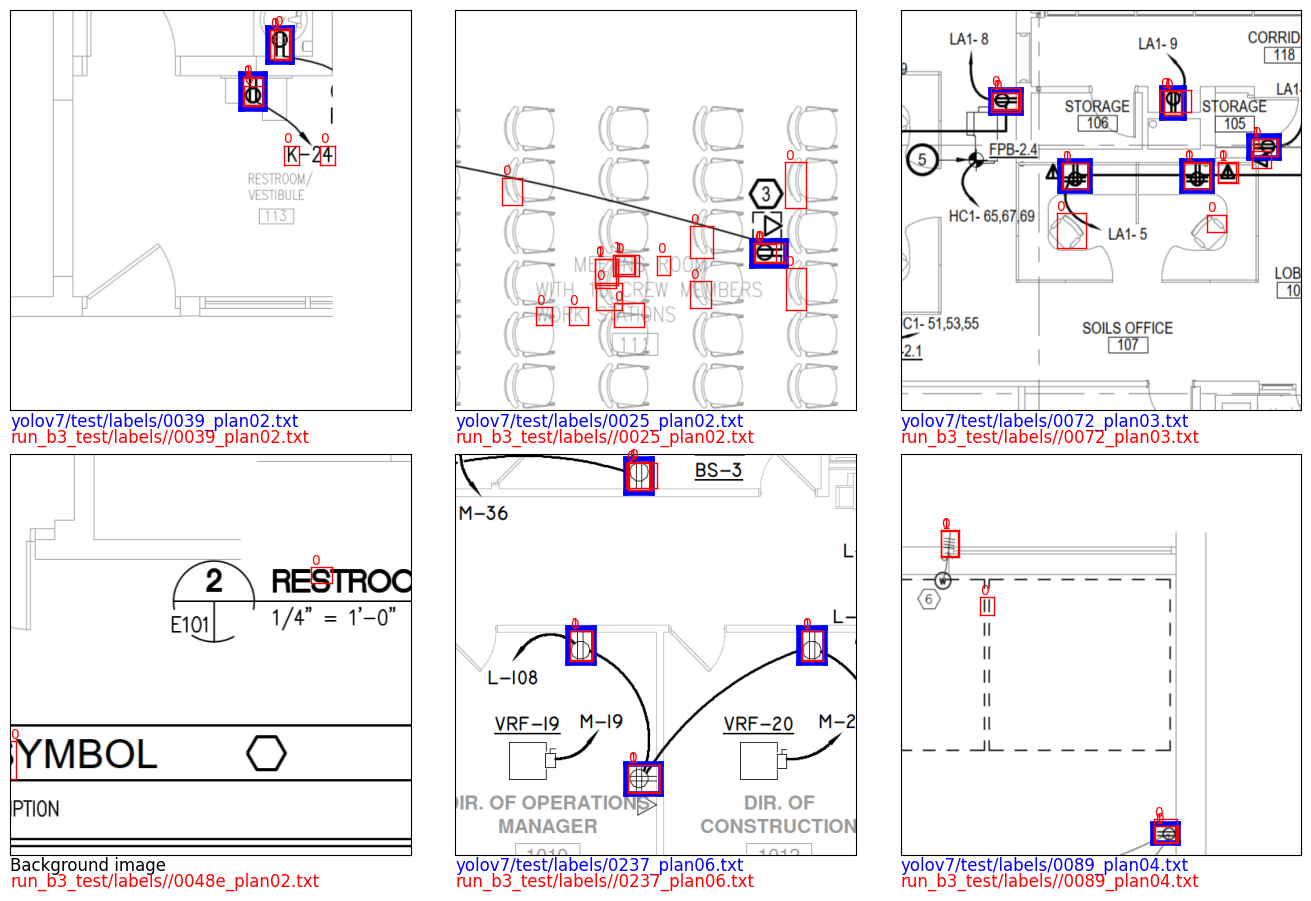

In [15]:
testimgpaths = ['yolov7/test/images/0039_plan02.png', 'yolov7/test/images/0025_plan02.png', 'yolov7/test/images/0072_plan03.png', 
                'yolov7/test/images/0048e_plan02.png', 'yolov7/test/images/0237_plan06.png', 'yolov7/test/images/0089_plan04.png']

utility_funcs.show_img2(testimgpaths, "run_b3_test/labels/", clr1="blue", clr2="red")

Compared to before, significantly fewer bounding boxes are output even at this very low confidence level! Let's try the b3 model weights on the 2nd test set 

### b3 weights: Evaluate on test set2 (unseen plans, some not from txdot)

In [ ]:
if "run_b3" not in os.listdir():
    if "run_b3.zip" not in os.listdir():
        !gdown -qq 1FZ_yqbyvqwQt5xop2FvI5krZmmn1mawh
    !unzip -qq run_b2.zip

In [16]:
if "test_manual_labels_unseen_plans.zip" not in os.listdir():
    !gdown -qq 1qtvl1TPhhH9zqFJUeS9q8t6ZUmLVx-3l
!unzip -qq test_manual_labels_unseen_plans.zip
!rm manually_labeled_images.csv

In [17]:
!rm -r yolov7/test/
test_files = os.listdir("images_manual")
src_paths = ["images_manual/", "labels_manual/"]
utility_funcs.move_images(src_paths, [], [], test_files)

Using confidence threshold = 0.2

In [18]:
run_name_test = "run_b3_test_set2"  # test run name
best_wght_path = "run_b3/best.pt"

!python yolov7/test.py --weights $best_wght_path --data yolov7/data/esr.yaml --img-size 512 --save-txt --task test --name $run_name_test --no-trace --conf-thres 0.2 

Namespace(weights=['run_b3/best.pt'], data='yolov7/data/esr.yaml', batch_size=32, img_size=512, conf_thres=0.2, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='run_b3_test_set2', exist_ok=False, no_trace=True, v5_metric=False)
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
test: Scanning 'yolov7/test/labels' images and labels... 108 found, 0 missi

Comparing run_b2 and run_b3 on the more challenging test set2 really shows the difference in performance. Before, precision on b2 was 0.37 and with b3 it's 0.7, almost twice as high. The recall was 0.55 with b2 weights and with b3 recall is 0.88. A rather significant improvement

In [ ]:
# save test results
test_zip = run_name_test+".zip"
basepath = "runs/test/"

!cp -r $basepath$run_name_test $run_name_test
!rm -rf $basepath$run_name_test

!zip -qq -r $test_zip $run_name_test
files.download(test_zip)

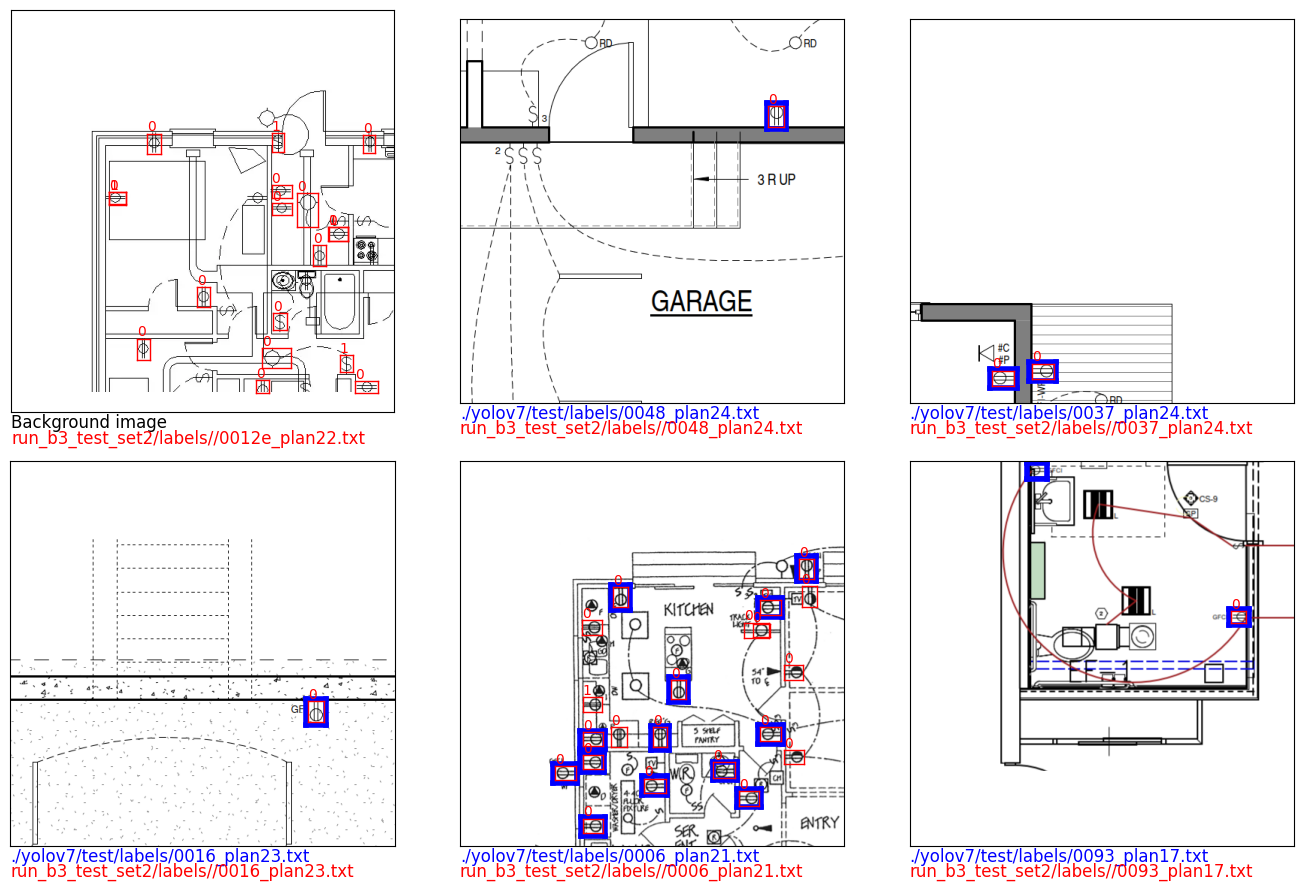

In [22]:
testimgpaths = ['./yolov7/test/images/0012e_plan22.png', './yolov7/test/images/0048_plan24.png', './yolov7/test/images/0037_plan24.png',
                './yolov7/test/images/0016_plan23.png', './yolov7/test/images/0006_plan21.png', './yolov7/test/images/0093_plan17.png']
                
utility_funcs.show_img2(testimgpaths, "run_b3_test_set2/labels/", clr1="blue", clr2="red")

Performance is visibly improved but still far from perfect.

## Model b4
####  - Changing the anchor boxes
All previous changes are kept.

The anchor boxes can roughly be thought of as candidate inital bounding boxes. They are divided in three different groups based on their size/scale and each group of anchors is associated to 1 of the 3 different model "heads".

For this task, the variation in scale between the 3 different heads, tuned for use on the MS COCO dataset, is not really necessary. The task is constrained in such a way that the size of the symbols in the images will be very similar.

Inspecting the output from previous fits will show that the BPR (Best Possible Recall) still is 1.0, meaning that the default anchors (and possible automatic recalculation) will be sufficient to predict the bounding boxes for the objects in the training set. However, for this model the idea is that manually adjusting the anchor box specification will allow for faster and more efficient training since fewer candidate boxes are inappropriate right from the start. The argument "--noautoanchor" is also supplied to the train.py script so that the box sizes specified in the custom .cfg file should be used.


In [23]:
# create a new custom config file by copying "yolov7.yaml...
# and changing line 2 where the number of classes is defined (originally 80 classes)

with open("/content/yolov7/cfg/training/yolov7.yaml", "r") as f:
    content = f.readlines()
    content[1] = "nc: 2  # number of classes\n"

    content[7] = "  - [16,17, 21,26, 25,22]  # P3/8\n"
    content[8] = "  - [22,32, 32,24, 26,37]  # P4/16\n"
    content[9] = "  - [36,27, 29,33, 37,36]  # P5/32\n"

with open("/content/yolov7/cfg/training/esr_v1.yaml", "w") as f:
    f.writelines(content)


# Create file that defines where..
# 1. the training, validation, test samples+labels are located
# 2. the number of classes
# 3. class names

with open("/content/yolov7/data/esr.yaml", "w") as f:
    f.write("train: ./yolov7/train\n")
    f.write("val: ./yolov7/valid\n")
    f.write("test: ./yolov7/test\n\n")
    f.write("# Classes\n")
    f.write("nc: 2  # number of classes\n")
    f.write("names: ['duplex', 'quad']")

In [24]:
with open("yolov7/data/hyp.scratch.p5.yaml", mode="r") as f:
  lines = f.readlines()

with open("yolov7/data/hyp.esr.p5.yaml", mode="w") as f:
  for line in lines:
    if line.split(':')[0] == "scale":
      f.write("scale: 0.3  # image scale (+/- gain)\n")

    elif line.split(':')[0] == "mosaic":
      f.write("mosaic: 0.5  # image mosaic (probability)\n")

    else:
      f.write(line)

In [23]:
run_name = "run_b4"
epochs = 100

!python yolov7/train.py --workers 8 --device 0 --batch-size 32 --weights yolov7_training.pt --data yolov7/data/esr.yaml --img 512 --cfg yolov7/cfg/training/esr_v1.yaml --name $run_name --epochs $epochs --hyp yolov7/data/hyp.esr.p5.yaml --noautoanchor

2023-04-24 00:07:16.166918: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 00:07:17.167502: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Namespace(weights='yolov7_training.pt', cfg='yolov7/cfg/training/esr_v1.yaml', data='yolov7/data/esr.yaml', hyp='yolov7/data/hyp.esr.p5.yaml', epochs=100, batch_size=32, img_size=[512, 512], rect=False, resume=False, nosave=False, notest=False, noautoanchor=True, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=8, project='runs/train', entity=None, name='run_b4

Compared

In [25]:
# save the best weights and other run outputs
run_zip = run_name+".zip"
basepath = "runs/train/"
wghts = "/weights"
best_wghts = "/best.pt"

!cp $basepath$run_name$wghts$best_wghts $basepath$run_name$best_wghts
!rm -rf $basepath$run_name$wghts
!cp -r $basepath$run_name $run_name
!rm -rf $basepath$run_name

!zip -qq -r $run_zip $run_name
files.download(run_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

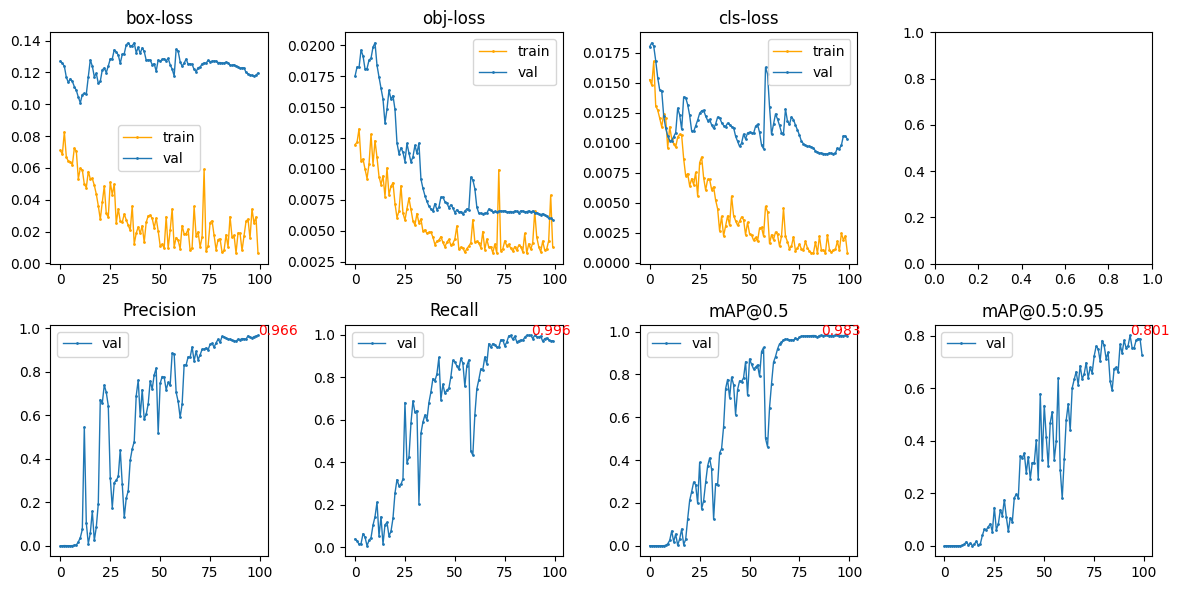

In [3]:
utility_funcs.plot_results_simple("run_b4/results.txt", annotate_best=True)

## Evaluate run_b4
#### run test.py on test image set1 with model b4 weights

In [7]:
if "run_b4" not in os.listdir():
    if "run_b4.zip" not in os.listdir():
        !gdown -qq 1NgvIT3QGUmO7dheQRG1emizsBOAVEwEI
    !unzip -qq run_b4.zip

In [8]:
if "test_manual_labels_020.zip" not in os.listdir():
    !gdown -qq 1ObgIwIKKa06vp4M2aq7SVz8Nh5tOLbq6
!unzip -qq test_manual_labels_020.zip


!rm -r yolov7/test  # remove existing test images and labels
test_files = os.listdir("test_manual_labels_020/images/")
src_paths = ["test_manual_labels_020/images/", "test_manual_labels_020/labels/"]
utility_funcs.move_images(src_paths, [], [], test_files)

!rm -r test_manual_labels_020

In [7]:
run_name_test = "run_b4_test"  # test run name
best_wght_path = "run_b4/best.pt"

!python yolov7/test.py --weights $best_wght_path --data yolov7/data/esr.yaml --img-size 512 --save-txt --task test --name $run_name_test --no-trace

Namespace(weights=['run_b4/best.pt'], data='yolov7/data/esr.yaml', batch_size=32, img_size=512, conf_thres=0.001, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='run_b4_test', exist_ok=False, no_trace=True, v5_metric=False)
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
test: Scanning 'yolov7/test/labels' images and labels... 41 found, 0 missing, 

In [8]:
# save test results
test_zip = run_name_test+".zip"
basepath = "runs/test/"

!cp -r $basepath$run_name_test $run_name_test
!rm -rf $basepath$run_name_test

!zip -qq -r $test_zip $run_name_test
files.download(test_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### run_b4: predcited labels on test set1 with 0.001 confidence threshold

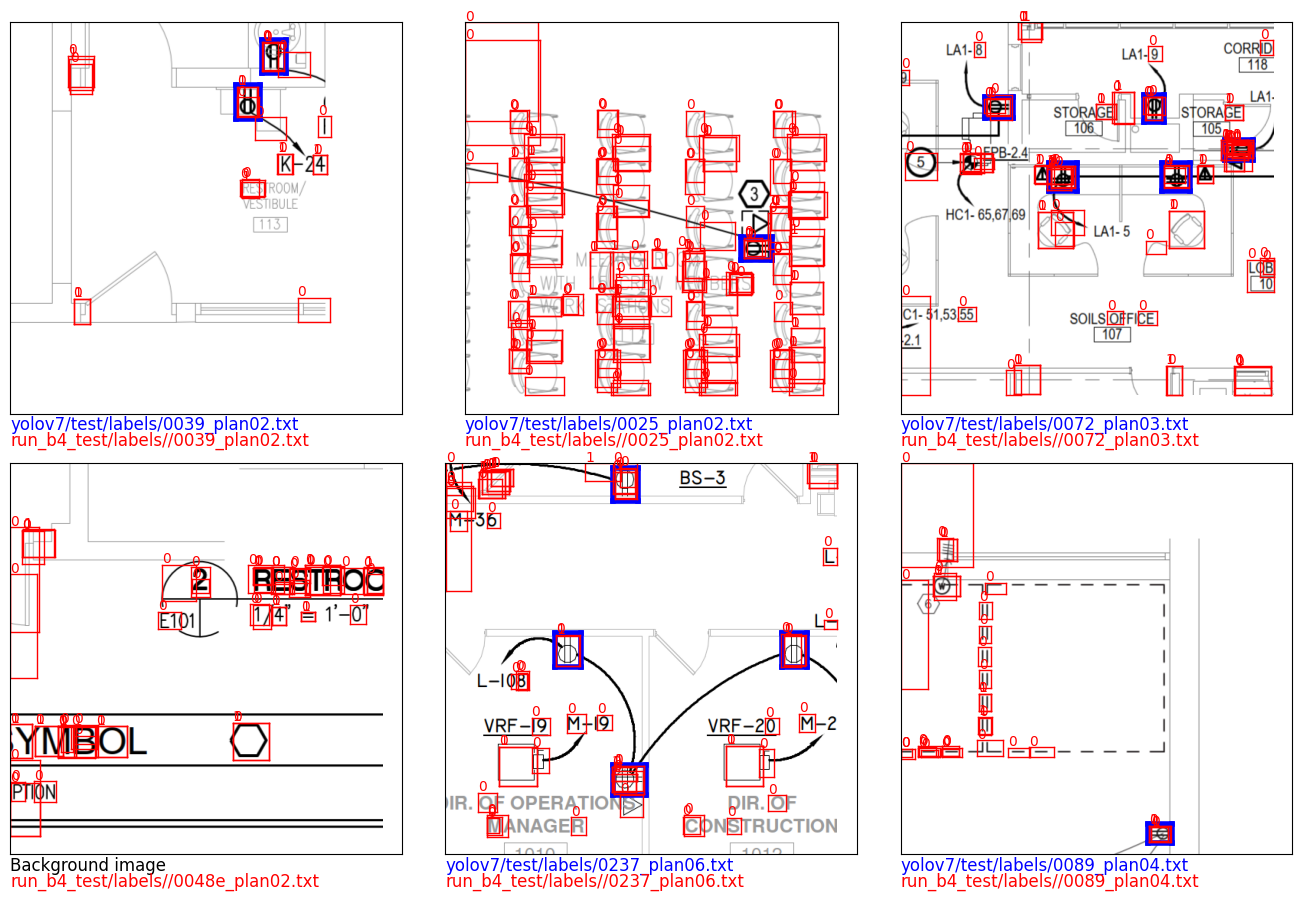

In [9]:
testimgpaths = ['yolov7/test/images/0039_plan02.png', 'yolov7/test/images/0025_plan02.png', 'yolov7/test/images/0072_plan03.png', 
                'yolov7/test/images/0048e_plan02.png', 'yolov7/test/images/0237_plan06.png', 'yolov7/test/images/0089_plan04.png']

utility_funcs.show_img2(testimgpaths, "run_b4_test/labels/", clr1="blue", clr2="red")

Compared to b3 at the same confidence level, significantly more bounding boxes are output

### b4 weights: Evaluate on test set2 (unseen plans, some not from txdot)

In [10]:
if "test_manual_labels_unseen_plans.zip" not in os.listdir():
    !gdown -qq 1qtvl1TPhhH9zqFJUeS9q8t6ZUmLVx-3l
!unzip -qq test_manual_labels_unseen_plans.zip
!rm manually_labeled_images.csv

In [11]:
!rm -r yolov7/test/
test_files = os.listdir("images_manual")
src_paths = ["images_manual/", "labels_manual/"]
utility_funcs.move_images(src_paths, [], [], test_files)

Using confidence threshold = 0.2

In [12]:
run_name_test = "run_b4_test_set2"  # test run name
best_wght_path = "run_b4/best.pt"

!python yolov7/test.py --weights $best_wght_path --data yolov7/data/esr.yaml --img-size 512 --save-txt --task test --name $run_name_test --no-trace --conf-thres 0.2 

Namespace(weights=['run_b4/best.pt'], data='yolov7/data/esr.yaml', batch_size=32, img_size=512, conf_thres=0.2, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='run_b4_test_set2', exist_ok=False, no_trace=True, v5_metric=False)
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
test: Scanning 'yolov7/test/labels' images and labels... 108 found, 0 missi

text

In [13]:
# save test results
test_zip = run_name_test+".zip"
basepath = "runs/test/"

!cp -r $basepath$run_name_test $run_name_test
!rm -rf $basepath$run_name_test

!zip -qq -r $test_zip $run_name_test
files.download(test_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

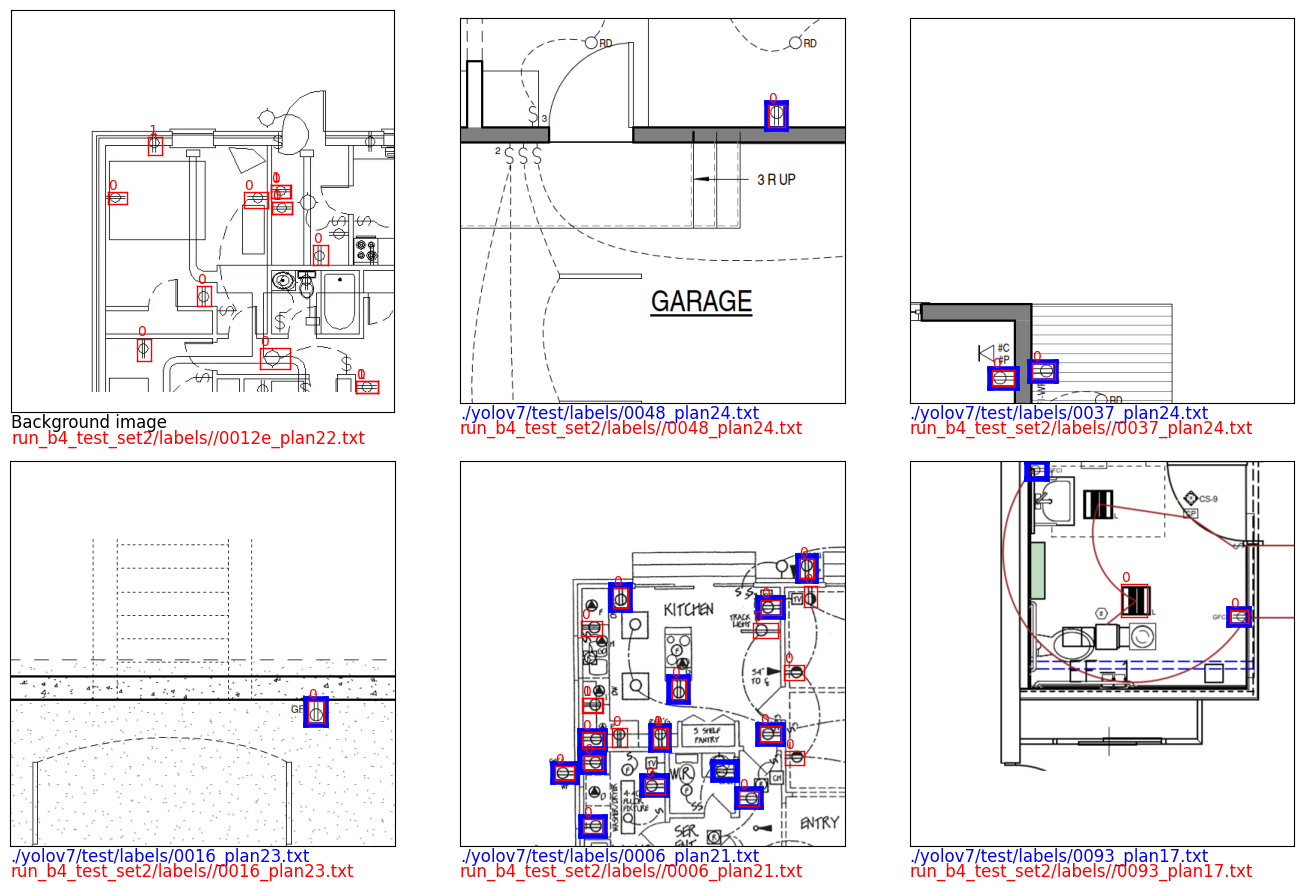

In [14]:
testimgpaths = ['./yolov7/test/images/0012e_plan22.png', './yolov7/test/images/0048_plan24.png', './yolov7/test/images/0037_plan24.png',
                './yolov7/test/images/0016_plan23.png', './yolov7/test/images/0006_plan21.png', './yolov7/test/images/0093_plan17.png']
                
utility_funcs.show_img2(testimgpaths, "run_b4_test_set2/labels/", clr1="blue", clr2="red")

# Model z1 and z2 
These model were trained "offline" using generated data. The resulting weights are fetched for evaluation on test set 1 and 2

# z1 weights
### Evaluate: run test.py with model z1 weights

In [25]:
!gdown -qq 19FUmJtnLRZAagbkOgIrpWhrRClXKYHZB
!unzip -qq run_z1.zip

#### Evaluation image set1

In [26]:
if "test_manual_labels_020.zip" not in os.listdir():
    !gdown -qq 1ObgIwIKKa06vp4M2aq7SVz8Nh5tOLbq6
!unzip -qq test_manual_labels_020.zip

In [27]:
!rm -r yolov7/test  # remove existing test images and labels
test_files = os.listdir("test_manual_labels_020/images/")
src_paths = ["test_manual_labels_020/images/", "test_manual_labels_020/labels/"]

utility_funcs.move_images(src_paths, [], [], test_files)

!rm -r test_manual_labels_020

In [30]:
run_name = "run_z1"
run_name_test = run_name+"_test_02conf"  # test run name
best_wght_path = run_name+"/best.pt"

!python yolov7/test.py --weights $best_wght_path --data yolov7/data/esr.yaml --img-size 512 --save-txt --task test --name $run_name_test --no-trace --conf-thres 0.2

Namespace(weights=['run_z1/best.pt'], data='yolov7/data/esr.yaml', batch_size=32, img_size=512, conf_thres=0.2, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='run_z1_test_02conf', exist_ok=False, no_trace=True, v5_metric=False)
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
test: Scanning 'yolov7/test/labels.cache' images and labels... 41 found, 

In [31]:
# save test results
test_zip = run_name_test+".zip"
basepath = "runs/test/"

!cp -r $basepath$run_name_test $run_name_test
!rm -rf $basepath$run_name_test

!zip -qq -r $test_zip $run_name_test
files.download(test_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

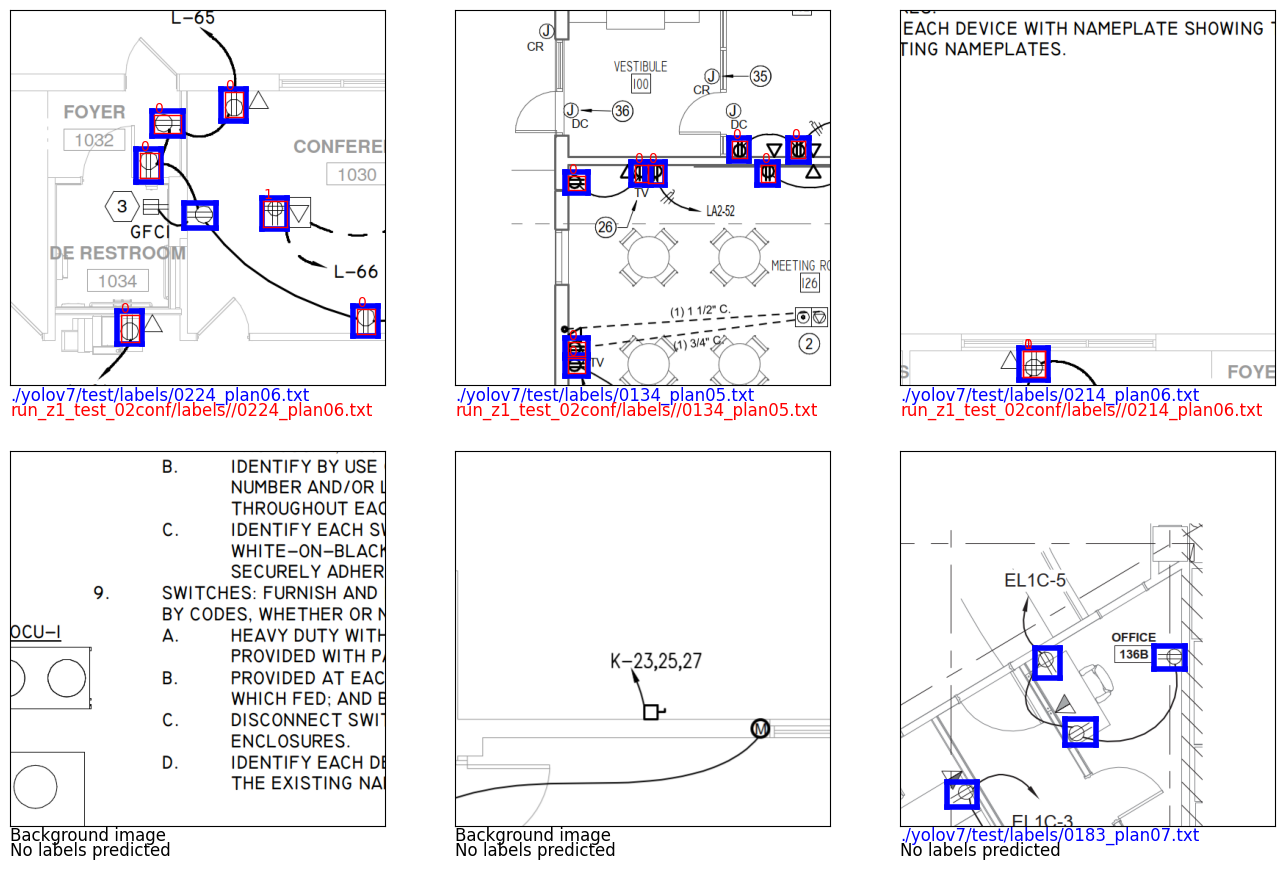

In [33]:
testimgpaths = ['./yolov7/test/images/0224_plan06.png', './yolov7/test/images/0134_plan05.png', './yolov7/test/images/0214_plan06.png',
                './yolov7/test/images/0210e_plan06.png', './yolov7/test/images/0011e_plan02.png', './yolov7/test/images/0183_plan07.png']

utility_funcs.show_img2(testimgpaths, "run_z1_test_02conf/labels/", clr1="blue", clr2="red")

### z1 weights: Test set2 (unseen plans, some not from txdot)

In [34]:
if "test_manual_labels_unseen_plans.zip" not in os.listdir():
    !gdown -qq 1qtvl1TPhhH9zqFJUeS9q8t6ZUmLVx-3l
!unzip -qq test_manual_labels_unseen_plans.zip
!rm manually_labeled_images.csv

In [35]:
!rm -r yolov7/test/  # remove existing test images and labels
test_files = os.listdir("images_manual")
src_paths = ["images_manual/", "labels_manual/"]

utility_funcs.move_images(src_paths, [], [], test_files)

In [36]:
run_name_test = run_name+"_test_set2"  # test run name
best_wght_path = run_name+"/best.pt"

!python yolov7/test.py --weights $best_wght_path --data yolov7/data/esr.yaml --img-size 512 --save-txt --task test --name $run_name_test --no-trace --conf-thres 0.2

Namespace(weights=['run_z1/best.pt'], data='yolov7/data/esr.yaml', batch_size=32, img_size=512, conf_thres=0.2, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='run_z1_test_set2', exist_ok=False, no_trace=True, v5_metric=False)
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
test: Scanning 'yolov7/test/labels' images and labels... 108 found, 0 missi

In [37]:
# save test results
test_zip = run_name_test+".zip"
basepath = "runs/test/"

!cp -r $basepath$run_name_test $run_name_test
!rm -rf $basepath$run_name_test

!zip -qq -r $test_zip $run_name_test
files.download(test_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

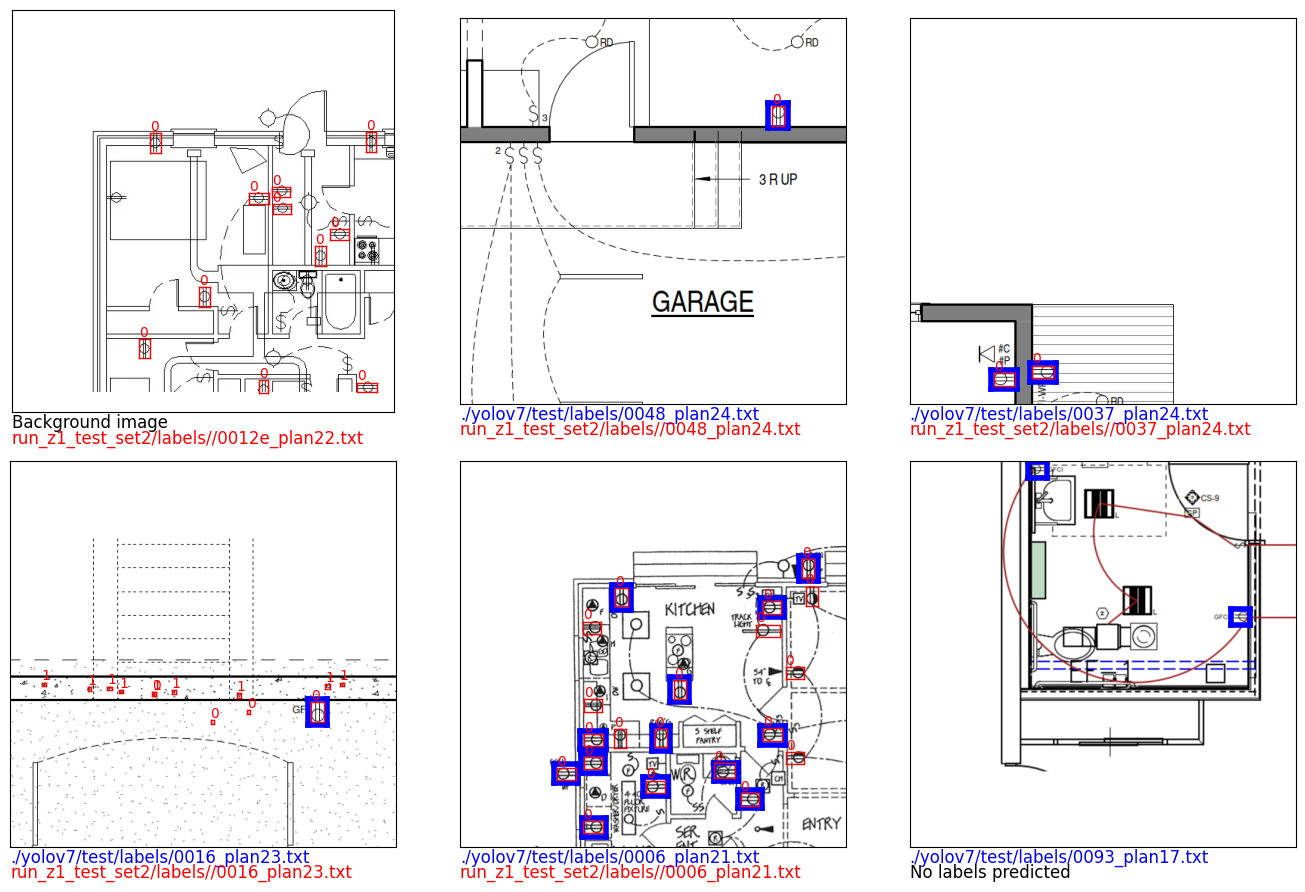

In [38]:
testimgpaths = ['./yolov7/test/images/0012e_plan22.png', './yolov7/test/images/0048_plan24.png', './yolov7/test/images/0037_plan24.png',
                './yolov7/test/images/0016_plan23.png', './yolov7/test/images/0006_plan21.png', './yolov7/test/images/0093_plan17.png']
                
utility_funcs.show_img2(testimgpaths, "run_z1_test_set2/labels/", clr1="blue", clr2="red")

# z2 weights
### Evaluate: run test.py with model z2 weights

In [16]:
!gdown -qq 1a1Ef4rOFO49uMl6YEcay7F61VJ5Buz7W
!unzip -qq run_z2.zip

#### Evaluation image set1

In [4]:
if "test_manual_labels_020.zip" not in os.listdir():
    !gdown -qq 1ObgIwIKKa06vp4M2aq7SVz8Nh5tOLbq6
!unzip -qq test_manual_labels_020.zip

In [ ]:
!rm -r yolov7/test  # remove existing test images and labels
test_files = os.listdir("test_manual_labels_020/images/")
src_paths = ["test_manual_labels_020/images/", "test_manual_labels_020/labels/"]

utility_funcs.move_images(src_paths, [], [], test_files)

!rm -r test_manual_labels_020

In [8]:
run_name = "run_z2"
run_name_test = run_name+"_test_02conf"  # test run name
best_wght_path = run_name+"/best.pt"

!python yolov7/test.py --weights $best_wght_path --data yolov7/data/esr.yaml --img-size 512 --save-txt --task test --name $run_name_test --no-trace --conf-thres 0.2

Namespace(weights=['run_z2/best.pt'], data='yolov7/data/esr.yaml', batch_size=32, img_size=512, conf_thres=0.2, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='run_z2_test_02conf', exist_ok=False, no_trace=True, v5_metric=False)
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
test: Scanning 'yolov7/test/labels' images and labels... 41 found, 0 miss

In [9]:
# save test results
test_zip = run_name_test+".zip"
basepath = "runs/test/"

!cp -r $basepath$run_name_test $run_name_test
!rm -rf $basepath$run_name_test

!zip -qq -r $test_zip $run_name_test
files.download(test_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

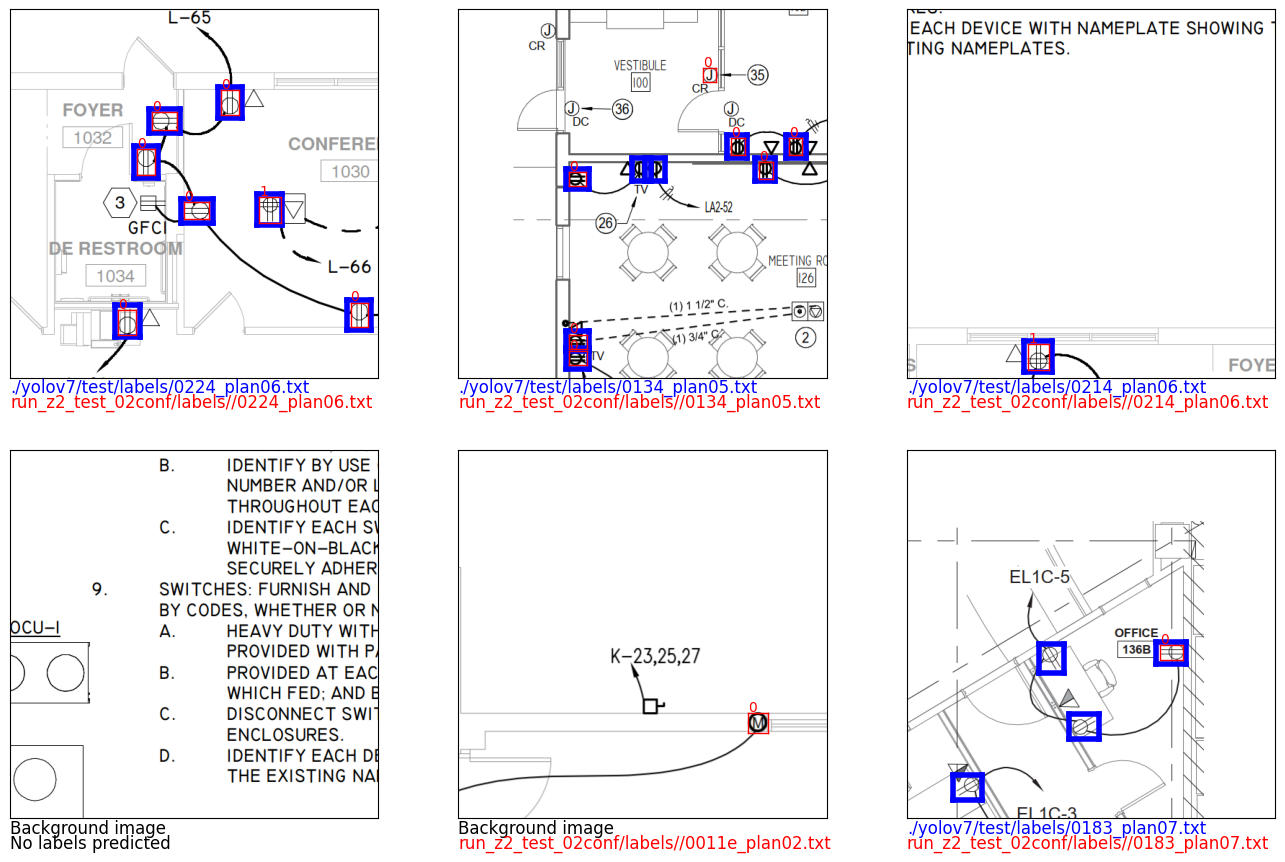

In [10]:
testimgpaths = ['./yolov7/test/images/0224_plan06.png', './yolov7/test/images/0134_plan05.png', './yolov7/test/images/0214_plan06.png',
                './yolov7/test/images/0210e_plan06.png', './yolov7/test/images/0011e_plan02.png', './yolov7/test/images/0183_plan07.png']

utility_funcs.show_img2(testimgpaths, "run_z2_test_02conf/labels/", clr1="blue", clr2="red")

### z2 weights: Test set2 (unseen plans, some not from txdot)

In [15]:
if "test_manual_labels_unseen_plans.zip" not in os.listdir():
    !gdown -qq 1qtvl1TPhhH9zqFJUeS9q8t6ZUmLVx-3l
!unzip -qq test_manual_labels_unseen_plans.zip
!rm manually_labeled_images.csv

In [17]:
!rm -r yolov7/test/  # remove existing test images and labels
test_files = os.listdir("images_manual")
src_paths = ["images_manual/", "labels_manual/"]

utility_funcs.move_images(src_paths, [], [], test_files)

In [13]:
run_name_test = run_name+"_test_set2"  # test run name
best_wght_path = run_name+"/best.pt"

!python yolov7/test.py --weights $best_wght_path --data yolov7/data/esr.yaml --img-size 512 --save-txt --task test --name $run_name_test --no-trace --conf-thres 0.2

Namespace(weights=['run_z2/best.pt'], data='yolov7/data/esr.yaml', batch_size=32, img_size=512, conf_thres=0.2, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='run_z2_test_set2', exist_ok=False, no_trace=True, v5_metric=False)
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
test: Scanning 'yolov7/test/labels' images and labels... 108 found, 0 missi

In [21]:
!rm -r runs

In [22]:
run_name = "run_z2"
run_name_test = run_name+"_test_set2_v5metric"  # test run name
best_wght_path = run_name+"/best.pt"

!python yolov7/test.py --weights $best_wght_path --data yolov7/data/esr.yaml --img-size 512 --save-txt --task test --name $run_name_test --no-trace --conf-thres 0.2 --v5-metric --iou-thres 0.4 --verbose

Namespace(weights=['run_z2/best.pt'], data='yolov7/data/esr.yaml', batch_size=32, img_size=512, conf_thres=0.2, iou_thres=0.4, task='test', device='', single_cls=False, augment=False, verbose=True, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='run_z2_test_set2_v5metric', exist_ok=False, no_trace=True, v5_metric=True)
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
test: Scanning 'yolov7/test/labels.cache' images and labels... 108 f

In [14]:
# save test results
test_zip = run_name_test+".zip"
basepath = "runs/test/"

!cp -r $basepath$run_name_test $run_name_test
!rm -rf $basepath$run_name_test

!zip -qq -r $test_zip $run_name_test
files.download(test_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

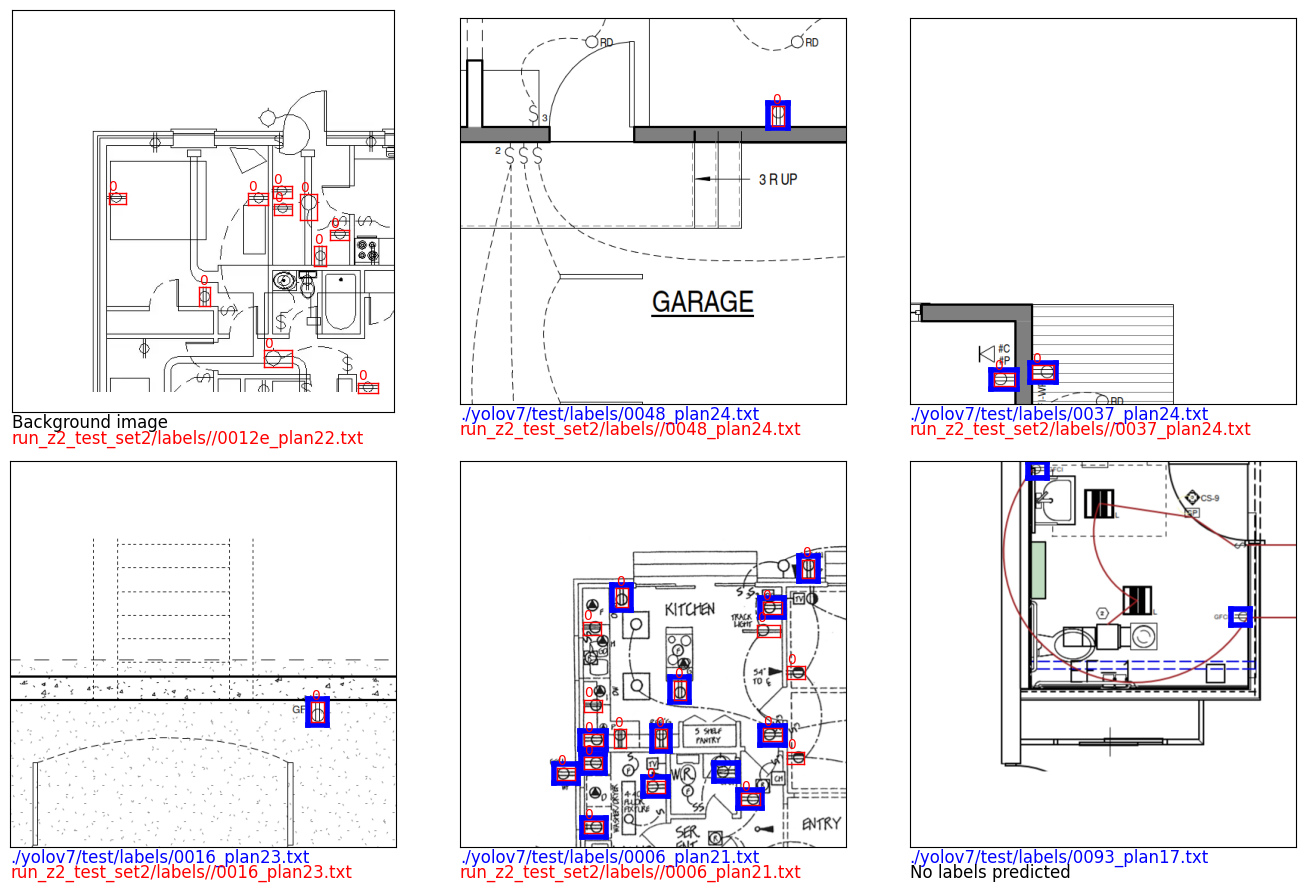

In [15]:
testimgpaths = ['./yolov7/test/images/0012e_plan22.png', './yolov7/test/images/0048_plan24.png', './yolov7/test/images/0037_plan24.png',
                './yolov7/test/images/0016_plan23.png', './yolov7/test/images/0006_plan21.png', './yolov7/test/images/0093_plan17.png']
                
utility_funcs.show_img2(testimgpaths, "run_z2_test_set2/labels/", clr1="blue", clr2="red")

In [39]:
# cleanup
for item in os.listdir():
  if "run" in item:
    !rm -r $item